# Image Captioning

## Setup

In [151]:
# Install croissant
!pip install -q mlcroissant

from mlcroissant import Dataset

In [152]:
# Import modules
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time
import textwrap
import os
import random
import ast
import re

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

from concurrent.futures import ThreadPoolExecutor
from nltk.tokenize import word_tokenize
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Load Dataset

In [ ]:
# Define a global variable that determines how to load the dataset
USE_CROISSANT = False

# Get the device for this session
devices = tf.config.list_physical_devices('GPU')
device_name = tf.config.experimental.get_device_details(devices[0])['device_name']

# If this session uses the A100 GPU, load the data with croissant
if "A100" in device_name:
  USE_CROISSANT = True

print(USE_CROISSANT)

True


In [153]:
USE_CROISSANT = False

### Download from HuggingFace to disk

In [109]:
if not USE_CROISSANT:
  # Download annotations (captions)
  !wget https://huggingface.co/datasets/nlphuji/flickr30k/resolve/main/flickr_annotations_30k.csv

  # Download and unzip images
  !wget https://huggingface.co/datasets/nlphuji/flickr30k/resolve/main/flickr30k-images.zip
  !unzip flickr30k-images.zip

--2024-11-23 23:56:49--  https://huggingface.co/datasets/nlphuji/flickr30k/resolve/main/flickr_annotations_30k.csv
Resolving huggingface.co (huggingface.co)... 13.35.210.61, 13.35.210.77, 13.35.210.66, ...
Connecting to huggingface.co (huggingface.co)|13.35.210.61|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/55/8b/558bef0bef5ef96807a371a60a509b6dca1f1f70b915af0c5ee35a2c92684941/395990db603ab8bafd5c7ab2746b22058bb1e75b78b3eb56ad755931364ac137?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27flickr_annotations_30k.csv%3B+filename%3D%22flickr_annotations_30k.csv%22%3B&response-content-type=text%2Fcsv&Expires=1732665409&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMjY2NTQwOX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy81NS84Yi81NThiZWYwYmVmNWVmOTY4MDdhMzcxYTYwYTUwOWI2ZGNhMWYxZjcwYjkxNWFmMGM1ZWUzNWEyYzkyNjg0OTQxLzM5NTk5MGRiNjAzYWI4YmFmZDVjN2FiMjc0NmIyMjA1OGJiMW

captions               sentids  \
0  [Two young guys with shaggy hair look at their...       [0, 1, 2, 3, 4]   
1  [Several men in hard hats are operating a gian...       [5, 6, 7, 8, 9]   
2  [A child in a pink dress is climbing up a set ...  [10, 11, 12, 13, 14]   
3  [Someone in a blue shirt and hat is standing o...  [15, 16, 17, 18, 19]   
4  [Two men, one in a gray shirt, one in a black ...  [20, 21, 22, 23, 24]   

   split        filename  img_id  
0  train  1000092795.jpg       0  
1  train    10002456.jpg       1  
2  train  1000268201.jpg       2  
3  train  1000344755.jpg       3  
4  train  1000366164.jpg       4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31014 entries, 0 to 31013
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   captions  31014 non-null  object
 1   sentids   31014 non-null  object
 2   split     31014 non-null  object
 3   filename  31014 non-null  object
 4   img_id    31014 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.2+ MB
None


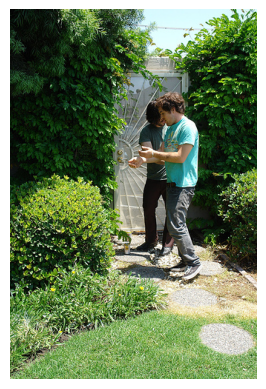

In [154]:
if not USE_CROISSANT:
  # Load annotations and image metadata into a dataframe
  flickr30k_df = pd.read_csv("flickr_annotations_30k.csv", converters={"raw": ast.literal_eval})
  flickr30k_df.rename(columns={"raw": "captions"}, inplace=True)
  display(flickr30k_df.head())
  print(flickr30k_df.info())

  # Verify that the images downloaded correctly
  img_file = flickr30k_df["filename"].values[0]
  img = Image.open(f"flickr30k-images/{img_file}")
  plt.imshow(img)
  plt.axis('off')
  plt.show()

### Download with Croissant

In [ ]:
if USE_CROISSANT:
  # Download Flickr30k metadata from hugging face with croissant
  flickr30k_ds = Dataset(jsonld="https://huggingface.co/api/datasets/nlphuji/flickr30k/croissant")
  records = flickr30k_ds.records("TEST")

  # Print the names of the available record sets
  record_sets = flickr30k_ds.metadata.record_sets
  print(record_sets)

  # Load the images and captions into a dataframe (uses RAM)
  flickr30k_df = pd.DataFrame(flickr30k_ds.records(record_set=record_sets[0].uuid))
  display(flickr30k_df.head())
  flickr30k_df.info()

  -  [Metadata(flickr30k)] Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.
  -  [Metadata(flickr30k)] Property "https://schema.org/datePublished" is recommended, but does not exist.
  -  [Metadata(flickr30k)] Property "https://schema.org/license" is recommended, but does not exist.
  -  [Metadata(flickr30k)] Property "https://schema.org/version" is recommended, but does not exist.
  -  `description` has cardinality `ONE`, but got a list
  -  `source` has cardinality `ONE`, but got a list


[RecordSet(uuid="TEST_splits"), RecordSet(uuid="TEST")]


TEST_splits/split_name
0                   test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   TEST_splits/split_name  1 non-null      object
dtypes: object(1)
memory usage: 136.0+ bytes


In [ ]:
if USE_CROISSANT:
  # Rename the columns
  flickr30k_df.rename(columns={
      "TEST/image": "image",
      "TEST/caption": "captions",
      "TEST/sentids": "sentids",
      "TEST/split": "split",
      "TEST/img_id": "img_id",
      "TEST/filename": "filename"
      },
      inplace=True
  )

  # Convert byte strings to strings
  flickr30k_df["split"] = flickr30k_df["split"].apply(lambda x: x.decode("utf-8"))
  flickr30k_df["img_id"] = flickr30k_df["img_id"].apply(lambda x: x.decode("utf-8"))
  flickr30k_df["filename"] = flickr30k_df["filename"].apply(lambda x: x.decode("utf-8"))
  flickr30k_df["captions"] = flickr30k_df["captions"].apply(lambda captions: [caption.decode("utf-8") for caption in captions])
  flickr30k_df["sentids"] = flickr30k_df["sentids"].apply(lambda ids: [id.decode("utf-8") for id in ids])
  display(flickr30k_df.head())

KeyError: 'split'

## Exploratory Data Analysis

In [111]:
# Helper function to search images by caption
def search_image_by_caption(text, show_image=False, exact_match=False):

  # Search all captions by text input (case insensitive)
  if exact_match:
    # Returns any image with a caption that matches the full input
    results = flickr30k_df[flickr30k_df["captions"].apply(lambda x: any(text.lower() in caption.lower() for caption in x))]
  else:
    # Returns any image with a caption that contains the keyword
    results = flickr30k_df[flickr30k_df["captions"].apply(lambda x: any(text.lower() in caption.lower().split() for caption in x))]

  if not results.empty and show_image:
    # Display a random image if there is more than one match
    n = len(results)
    idx = 0 if n <= 1 else random.randint(0, n-1)
    filename = results["filename"].values[idx]

    # If using croissant, retrieve the image from the dataframe
    # else, load the image from disk
    if USE_CROISSANT:
      img = results["image"].values[idx]
    else:
      img = Image.open(f"flickr30k-images/{filename}")

    # Plot image
    plt.imshow(img)
    plt.axis('off')
    print(filename)
    plt.show()

  return results if not results.empty else "No matches."

7033675245.jpg


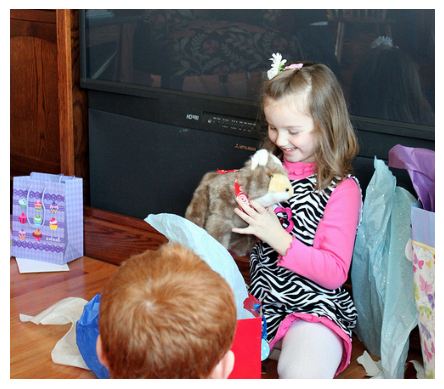

captions  \
1322   [A tall, thin, brunette girl wearing combat bo...   
7853   [There is a person in zebra striped pants and ...   
20566  [Two young women walking, one tall, blond, mod...   
22380  [Some people standing at the corner of a stree...   
22965  [A young girl with blue and pink ribbons in he...   
23572  [An African-American young man is sitting on a...   
26529  [A person dressed up like a panda has surprise...   
28953  [A girl, about 8 years old, is sitting in fron...   
29619  [A girl wearing a black bikini jumps into a la...   

                                        sentids  split        filename  img_id  
1322             [6610, 6611, 6612, 6613, 6614]  train  1400424834.jpg    1322  
7853        [39265, 39266, 39267, 39268, 39269]  train   270684372.jpg    7853  
20566  [102830, 102831, 102832, 102833, 102834]  train  4603100449.jpg   20566  
22380  [111900, 111901, 111902, 111903, 111904]  train  4756001275.jpg   22380  
22965  [114825, 114826, 114827, 114828, 114829]  train  4805835848.jpg   22965  
23572  [117860, 117861, 117862, 117863, 117864]  train  4851225205.jpg   23572  
26529  [132645, 132646, 132647, 132648, 132649]  train  5582687203.jpg   26529  
28953  [144765, 144766, 144767, 144768, 144769]  train  7033675245.jpg   28953  
29619  [148095, 148096, 148097, 148098, 148099]  train   755396653.jpg   29619

In [112]:
# Test image search helper function (keyword search)
search_image_by_caption("zebra", show_image=True)

5450688421.jpg


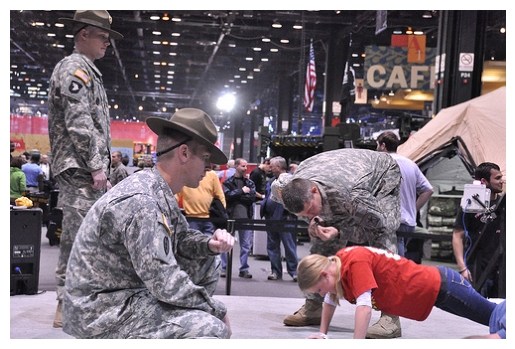

captions  \
26308  [Two soldiers at an event center are watching ...   

                                        sentids  split        filename  img_id  
26308  [131540, 131541, 131542, 131543, 131544]  train  5450688421.jpg   26308

In [113]:
# Test image search helper function (exact match)
search_image_by_caption("Think you can do as many as the lieutenant?", show_image=True, exact_match=True)

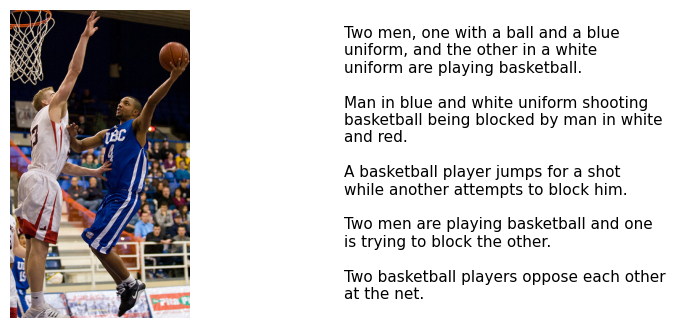

In [114]:
# Pick a random image
rs = flickr30k_df.sample(n=1)

# Plot the image and its captions
fig, ax = plt.subplots(1, 2, figsize=(6, 4), gridspec_kw={'width_ratios': [5, 1]})

# Load the image
if USE_CROISSANT:
  img = rs["image"].values[0]
else:
  img_name = rs["filename"].values[0]
  img = Image.open(f"flickr30k-images/{img_name}")

# Plot the image
ax[0].imshow(img)
ax[0].set_axis_off()

# Plot the captions
captions = rs["captions"].iloc[0]
ax[1].text(0.5, 0.5, "\n\n".join([textwrap.fill(caption, width=40) for caption in captions]), va='center', fontsize=11)
ax[1].set_axis_off()

plt.subplots_adjust(wspace=0.1)
plt.show()

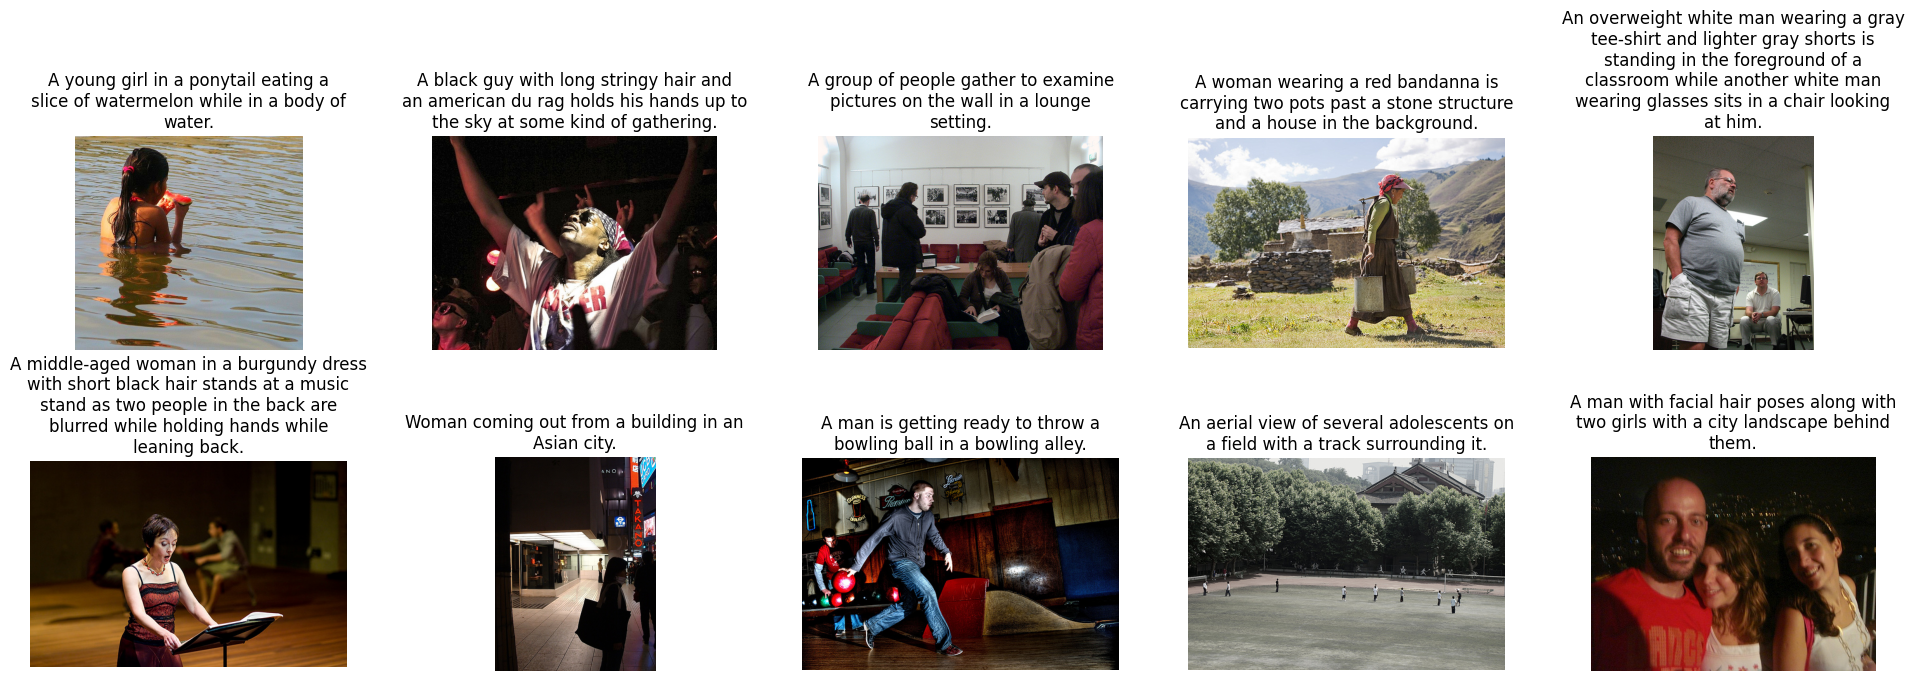

In [115]:
# Print a random sample of 10 images and their captions
rs = flickr30k_df.sample(n=10)

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

axs = axs.flatten()

# Plot each image and its first caption
for i, ax in enumerate(axs):
  if USE_CROISSANT:
    img = rs["image"].values[i]
  else:
    img_name = rs["filename"].values[i]
    img = Image.open(f"flickr30k-images/{img_name}")
  ax.imshow(img)
  caption = rs["captions"].iloc[i][0]
  ax.set_title(textwrap.fill(caption, width=40))
  ax.set_axis_off()

fig.tight_layout(pad=5.0)
plt.show()

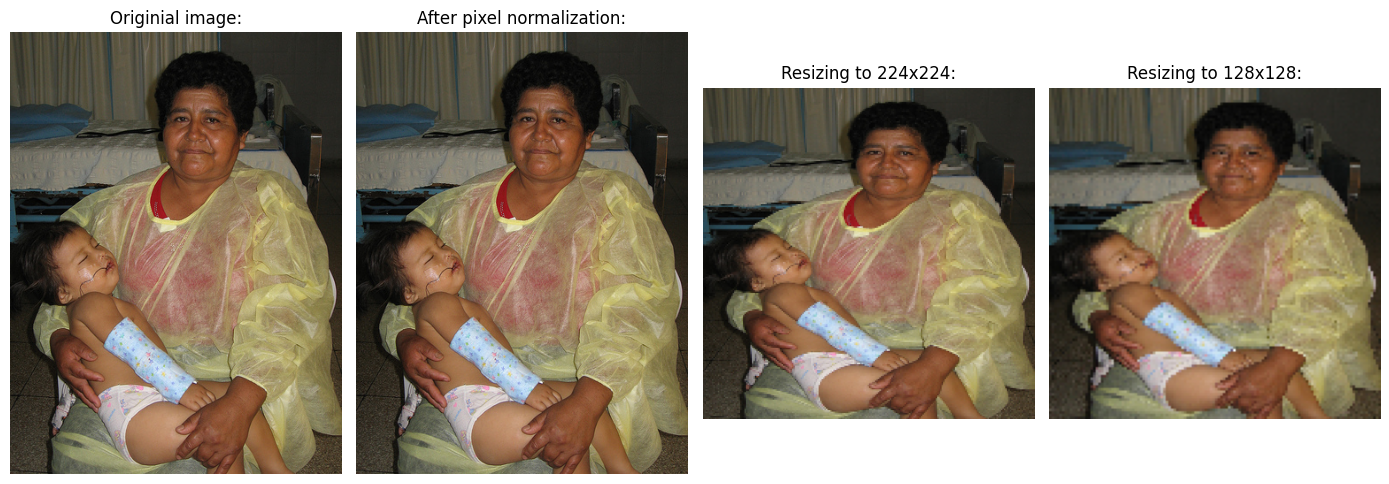

In [116]:
# Test image preprocessing methods
rs = flickr30k_df.sample(n=1)

# Load the image
if USE_CROISSANT:
  img = rs["image"].values[0]
else:
  img_name = rs["filename"].values[0]
  img = Image.open(f"flickr30k-images/{img_name}")

# Normalize the pixel values
img_tensor = tf.convert_to_tensor(img)
img_norm = img_tensor/255

# Resize the image to 224x224
img_224 = tf.image.resize(img_norm, [224, 224])

# Resize the image to 128x128
img_128 = tf.image.resize(img_norm, [128, 128])

# Plot the original image and each of its transformations
fig, ax = plt.subplots(1, 4, figsize=(14, 7))
ax[0].set_title("Originial image:")
ax[0].imshow(img)
ax[0].axis('off')
ax[1].set_title("After pixel normalization:")
ax[1].imshow(img_norm)
ax[1].axis('off')
ax[2].set_title("Resizing to 224x224:")
ax[2].imshow(img_224)
ax[2].axis('off')
ax[3].set_title("Resizing to 128x128:")
ax[3].imshow(img_128)
ax[3].axis('off')

fig.tight_layout()
plt.show()

In [117]:
# Get all of the captions for EDA
all_captions = [caption for captions in flickr30k_df["captions"] for caption in captions]
all_captions[:5]

['Two young guys with shaggy hair look at their hands while hanging out in the yard.',
 'Two young, White males are outside near many bushes.',
 'Two men in green shirts are standing in a yard.',
 'A man in a blue shirt standing in a garden.',
 'Two friends enjoy time spent together.']

Total number of captions: 155070
Mean caption length: 63.2
Median caption length: 58.0
Caption length standard dev: 26.68
Min length: 7
Q1: 45.0
Q3: 75.0
95th percentile: 113.0
Max length: 402


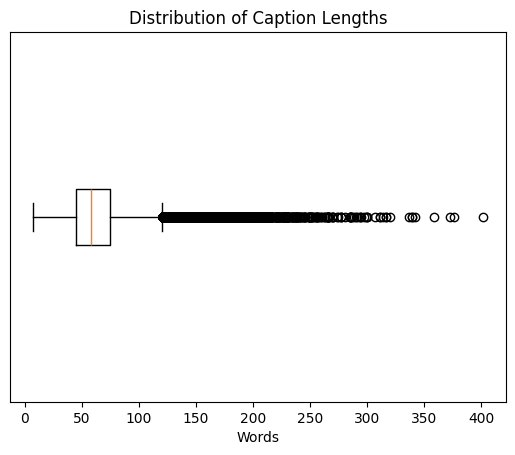

In [118]:
# Compute descriptive statistics for the captions
print(f"Total number of captions: {len(all_captions)}")

caption_lengths = [len(caption) for caption in all_captions]

print(f"Mean caption length: {np.round(np.mean(caption_lengths), 2)}")
print(f"Median caption length: {np.median(caption_lengths)}")
print(f"Caption length standard dev: {np.round(np.std(caption_lengths), 2)}")
print(f"Min length: {np.min(caption_lengths)}")
print(f"Q1: {np.quantile(caption_lengths, 0.25)}")
print(f"Q3: {np.quantile(caption_lengths, 0.75)}")
print(f"95th percentile: {np.quantile(caption_lengths, 0.95)}")
print(f"Max length: {np.max(caption_lengths)}")

# Plot the distribution
plt.title("Distribution of Caption Lengths")
plt.xlabel("Words")
plt.boxplot(caption_lengths, vert=0)
plt.yticks([])
plt.show()

In [119]:
# Find non-alphabetic characters in the captions
unique_chars = {char for caption in all_captions for char in caption if not char.isalpha()}
print(unique_chars)

{')', ':', ';', '&', '1', '!', '"', "'", '-', ',', '@', '9', '2', '7', '$', '`', ' ', '4', '#', '5', '+', '?', '(', '6', '.', '0', '=', '%', '8', '3'}


In [120]:
# Inspect instances of captions that use non-alphabetic characters (pound sign)
special_char_captions = [caption for caption in all_captions if "#" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 41


['A UH football player, #15, stands near the edge of the field ready to throw the ball while his teammate blocks an opponent.',
 'A little-league baseball player, wearing a white #19 jersey, successfully hits the ball.',
 'A football player is in a red and white uniform Sooners #28.',
 'A black greyhound, with a green and white jersey (#7) is running on a track.',
 'The #2 greyhound dog is running around a track.']

In [121]:
# Inspect instances of captions that use non-alphabetic characters (at sign)
special_char_captions = [caption for caption in all_captions if "@" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 3


['@ men are kneeling with their hands in front of them.',
 '@ people are cleaning windows in a dark environment.',
 '@ males wearing a black shirt and a brown shirt are looking at vegetation.']

In [122]:
# Inspect instances of captions that use non-alphabetic characters (percent sign)
special_char_captions = [caption for caption in all_captions if "%" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 12


['Man outside in the rain promoting a 50 % off sale.',
 'An elderly man held the "COLLEGE KRUGT DINERS EN 3 %" sign as he stood near the brick building.',
 'A group of women are all sitting in a department store looking at some papers or booklets, and a large sign indicates 40 % off sale.',
 '2 men getting ready to cross the street under the 25 % off sign.',
 '2 rows of woman walking towards each other on the sidewalk outside of a store with a boy 50 % sign on the golden framed windows.']

In [123]:
# Inspect instances of captions that use non-alphabetic characters (colon)
special_char_captions = [caption for caption in all_captions if ":" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[10:15]

Total instances: 31


['Left to right : a girl in an orange coat, a young boy with a camera and red coat, and a woman with a scarf.',
 "Celebrating St. Patrick's Day at 2:10 pm &amp; an police officer is going inside a room.",
 'A group of men finish a fund raising run for Haiti in 28:24.',
 'A large gold trimmed clock indicates that the time is 1:10.',
 'A woman in a blue coat walks in front of a sign with green men walking under the two words :berlin and kathmandu']

In [124]:
# Inspect instances of captions that use non-alphabetic characters (equal sign)
special_char_captions = [caption for caption in all_captions if "=" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 2


['Two young children RIF=ding sleds down the snow.',
 'People passing through an open market, while an older woman leans in front of a chilled bin on=f seafood.']

In [125]:
# Inspect instances of captions that use non-alphabetic characters (plus sign)
special_char_captions = [caption for caption in all_captions if "+" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 3


['A Chinese + man and younger boy in some type of worship place worshiping.',
 'An elderly woman wearing a green parka +is walking with a cane near an intersection.',
 '8+ people sitting on wood benches are viewing 8 people in brown.']

In [126]:
# Inspect instances of captions that use non-alphabetic characters (ampersand)
special_char_captions = [caption for caption in all_captions if "&" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 90


['Grocery store employee, dressed in a red apron &amp; a baseball cap, sits on a ledge in front of the store.',
 'Two ladies are cooking &amp; talking and two gentlemen are talking in the opposite site of the kitchen.',
 'A woman in a black shirt sitting behind a booth with a sign that reads "Programmes &amp; Ice Cream."',
 'Eight gentlemen are working with stone &amp; tile.',
 'A dozen workers wearing uniforms &amp; sanitation hats are working on an assembly line in a factory.']

In [127]:
# Inspect instances of captions that use non-alphabetic characters (question mark)
special_char_captions = [caption for caption in all_captions if "?" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions

Total instances: 38


['A crowd admiring modern art?',
 'The green team lifts a player up in victory after a hard game, but will the red team interfere?',
 'It takes a real man to clean a bucket with who knows what in it?',
 "That hotdog just wasn't going down right, was it the drinking or the burnt dog?",
 'People walking through a short tunnel with "Where are you?" written on the wall.',
 'A man walks under a bridge and reads grafitti that reads "WHERE ARE YOU"?',
 'A man with a cigerette walks past graffitti which says "Where are you?"',
 'A man is walking next to a wall with "Where are you?" painted on it.',
 'A man walking reads a wall asking "Where are you?".',
 'How do we get to the other side?',
 'A person riding transit (catching?) a paper bag.',
 'Two people pose for a picure holding a card that says "know what this is?"',
 'Two girls hold up a card reading "know what this is"?',
 'Man with cupcakes and coffee contemplating the statement "who are you?"',
 'A man in glasses writes the message "Who 

460921330.jpg


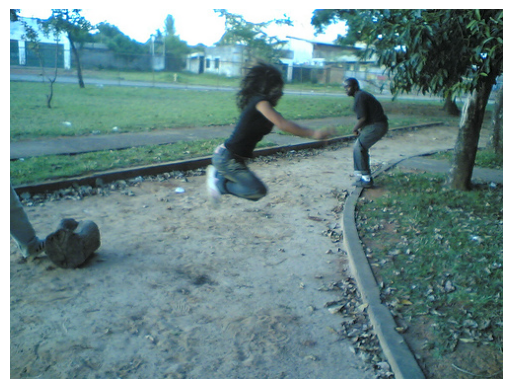

['A girl in a black shirt is jumping in a sandy area, and a man in a black shirt is bending over in the background.',
 "Did someone yell snake? Because it seems she's out of here!",
 'A woman jumping as a man idly watches her in midair.',
 'She is jumping high in the air.',
 'People outdoors at a park.']

In [128]:
results = search_image_by_caption("Did someone yell snake? Because it seems she's out of here!", show_image=True, exact_match=True)
results["captions"].iloc[0]

In [129]:
# Inspect instances of captions that use non-alphabetic characters (exclamation mark)
special_char_captions = [caption for caption in all_captions if "!" in caption]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 96


['Looks like everyone is getting good gas mileage here with all these beautiful scooters!',
 'Man on an ATV catching air!',
 'Roller derby girls waiting for the next round of action!',
 'A sweet young lady deciding whats for breakfast!',
 'A yellow taxi cab with a sign reading "MAMA MIA!" on it, and a guy sitting in the back.']

In [130]:
# Inspect instances of captions that use non-alphabetic characters (numbers)
special_char_captions = [caption for caption in all_captions if any(char in caption for char in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])]
print(f"Total instances: {len(special_char_captions)}")
special_char_captions[:5]

Total instances: 1776


['2 kids playing on a seesaw',
 'Small group of 5 white males in white suits hanging out by the back of a van in a parking lot talking.',
 '2 female babies eating chips.',
 'Man walking up to silver 4-wheeled chair',
 'A man in an orange shirt sings for the crowd below a sign that says Lucky 13.']

## Caption Preprocessing

In [155]:
# Save all the captions before cleaning to compare difference in vocabulary size
all_captions_raw = [caption for captions in flickr30k_df["captions"] for caption in captions]

In [156]:
def preprocess_captions(captions, add_seq_tokens=True):
  cleaned_captions = []
  for caption in captions:
    # Convert caption to lowercase
    caption = caption.lower()

    # Remove punctuation
    caption = re.sub(r"[.,;!?`]", "", caption)

    # Replace pound sign with the word number
    caption = caption.replace("#", "number")

    # Replace percent sign with the word percent
    caption = caption.replace("%", "percent")

    # Replace ampersand with the word and
    caption = caption.replace("&amp", "and")

    # Remove other characters that are not useful
    caption = re.sub(r"[@+=()]", "", caption)

    # Remove excess whitespace
    caption = re.sub(r"\s+", " ", caption).strip()

    if add_seq_tokens:
      caption = "startseq " + caption + " endseq"

    cleaned_captions.append(caption)

  return cleaned_captions

In [157]:
# Test the text preprocessing method on a single text
test_caption = ["Test.  caption (12), &amp; 34 @; + # % !", "(anoth=r) test caption"]
print(f"Original captions: {test_caption}")
print(f"After cleaning: {preprocess_captions(test_caption)}")

Original captions: ['Test.  caption (12), &amp; 34 @; + # % !', '(anoth=r) test caption']
After cleaning: ['startseq test caption 12 and 34 number percent endseq', 'startseq anothr test caption endseq']


In [158]:
# Apply preprocessing method to all the captions
flickr30k_df["captions"] = flickr30k_df["captions"].apply(preprocess_captions)
flickr30k_df["captions"].head()

0    [startseq two young guys with shaggy hair look...
1    [startseq several men in hard hats are operati...
2    [startseq a child in a pink dress is climbing ...
3    [startseq someone in a blue shirt and hat is s...
4    [startseq two men one in a gray shirt one in a...
Name: captions, dtype: object

In [159]:
# Get all of the captions
all_captions_cleaned = [caption for captions in flickr30k_df["captions"] for caption in captions]

## Image Preprocessing

In [136]:
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_densenet

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_inception

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet

In [137]:
class PretrainedCNN:
  def __init__(self, model, preprocess_method, input_shape):
    self.model = model
    self.preprocess_method = preprocess_method
    self.input_shape = input_shape

  def preprocess_image(self, img):
    return self.preprocess_method(img)

  def extract_img_features(self, image_files, batch_size):
    image_features = []
    for i in range(0, len(image_files), batch_size):
      batch = image_files[i:i+batch_size]
      batch_imgs = np.stack([
          self.preprocess_method(
              tf.image.resize(
                  tf.image.decode_jpeg(tf.io.read_file(f"flickr30k-images/{file}")),
                  [self.input_shape[0], self.input_shape[1]]
              )
          )
          for file in batch
      ])
      batch_img_features = self.model(batch_imgs)
      image_features.extend(batch_img_features)

    return image_features

In [45]:
densenet169 = DenseNet169(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling='avg',
)

pretrained_cnn_densenet169 = PretrainedCNN(densenet169, preprocess_input_densenet, (224, 224))

In [138]:
inceptionv3 = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling='avg',
)

pretrained_cnn_inceptionv3 = PretrainedCNN(inceptionv3, preprocess_input_inception, (224, 224))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
resnet50 = ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling='avg',
)

pretrained_cnn_resnet50 = PretrainedCNN(resnet50, preprocess_input_resnet, (224, 224))

In [139]:
image_files = flickr30k_df["filename"].tolist()
image_features = pretrained_cnn_inceptionv3.extract_img_features(image_files, 128)
flickr30k_df["image_features"] = image_features

In [140]:
flickr30k_df.head()

captions               sentids  \
0  [startseq two young guys with shaggy hair look...       [0, 1, 2, 3, 4]   
1  [startseq several men in hard hats are operati...       [5, 6, 7, 8, 9]   
2  [startseq a child in a pink dress is climbing ...  [10, 11, 12, 13, 14]   
3  [startseq someone in a blue shirt and hat is s...  [15, 16, 17, 18, 19]   
4  [startseq two men one in a gray shirt one in a...  [20, 21, 22, 23, 24]   

   split        filename  img_id  \
0  train  1000092795.jpg       0   
1  train    10002456.jpg       1   
2  train  1000268201.jpg       2   
3  train  1000344755.jpg       3   
4  train  1000366164.jpg       4   

                                      image_features  
0  (tf.Tensor(0.0949308, shape=(), dtype=float32)...  
1  (tf.Tensor(0.63391894, shape=(), dtype=float32...  
2  (tf.Tensor(0.27823332, shape=(), dtype=float32...  
3  (tf.Tensor(0.65343285, shape=(), dtype=float32...  
4  (tf.Tensor(0.25891724, shape=(), dtype=float32...

In [49]:
# flickr30k_df.to_pickle("flickr30k.pkl")

In [ ]:
# flickr30k_df = pd.read_pickle("flickr30k.pkl")
# flickr30k_df.head()

## Caption Encoder and Data Generator base clases

In [52]:
# Caption encoder base class
# Must specify a method of encoding a caption and decoding a caption
class CaptionEncoder:
  def __init__(self, vocab, seq_length):
    # Set the vocabulary, vocabulary size, and length of the sequences
    self.vocab = vocab
    self.vocab_size = len(vocab)
    self.seq_length = seq_length

  # Encoding method
  def encode(self, caption):
    pass

  # Decoding method
  def decode(self, encoding):
    pass

In [160]:
# Data generator base class
# Must specify __getitem__ and __len__
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, data, batch_size, shuffle=True):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle

  # Customizes the object accessor [] to retrieve the batch at a particular index
  def __getitem__(self, idx):
    pass

  # Customizes built in len() method to return the number of batches per epoch
  def __len__(self):
    pass

  # Specify what to do at the end of a training epoch (optional)
  def on_epoch_end(self):
    pass

## Data split

In [161]:
# Split data into train test and val sets
train_df = flickr30k_df[flickr30k_df["split"] == 'train']
print(train_df.info())

test_df = flickr30k_df[flickr30k_df["split"] == 'test']
print(test_df.info())

val_df = flickr30k_df[flickr30k_df["split"] == 'val']
print(val_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 29000 entries, 0 to 31013
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   captions  29000 non-null  object
 1   sentids   29000 non-null  object
 2   split     29000 non-null  object
 3   filename  29000 non-null  object
 4   img_id    29000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 25 to 30943
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   captions  1000 non-null   object
 1   sentids   1000 non-null   object
 2   split     1000 non-null   object
 3   filename  1000 non-null   object
 4   img_id    1000 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 46.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1014 entries, 67 to 30999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  -----

## Models

### CNN + TBD

In [162]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions_cleaned)

In [ ]:
tokenizer.word_index['startseq']

2

In [ ]:
tokenizer.word_index['endseq']

3

In [ ]:
tokenizer.index_word[1]

'a'

In [144]:
# Define a class that builds a data generator object for dynamically loading data
class CustomDataGenerator(DataGenerator):
  def __init__(self, df, vocab_size, max_seq_len=113, batch_size=32, shuffle=True):
    super().__init__(df, batch_size, shuffle)
    self.data = df
    self.vocab_size = vocab_size
    self.max_seq_len = max_seq_len

  # Customizes the object accessor [] to retrieve the batch at a particular index
  def __getitem__(self, idx):

    # Get the range of indices for this batch
    low = idx * self.batch_size
    high = min(low + self.batch_size, len(self.data))

    # Retrieve the batch
    batch = self.data[low:high]

    batch_image_features = batch["image_features"]
    batch_captions = batch["captions"]

    image_tensors = []
    caption_sequences = []
    y = []

    for img, captions in zip(batch_image_features, batch_captions):
      # caption_idx = random.randint(0, 4)
      # caption = captions[caption_idx]
      for caption in captions:
        encoding = tokenizer.texts_to_sequences([caption])[0]

        for i in range(1, len(encoding)):
            # Create input and output sequences from the captions, e.g.
            # <START> -> a
            # <START> a -> sample
            # <START> a sample -> caption

          caption_input, output = encoding[:i], encoding[i]
          caption_input = pad_sequences(
              [caption_input],
              maxlen=self.max_seq_len,
              padding="post",
              truncating="post"
          )[0]
          output = to_categorical([output], num_classes=self.vocab_size)[0]

          image_tensors.append(img)
          caption_sequences.append(caption_input)
          y.append(output)

    # Return a batch of images and captions
    return (np.array(image_tensors), np.array(caption_sequences)), np.array(y)

  # Customize built in len() method to return the number of batches per epoch
  def __len__(self):
    return int(np.ceil(len(self.data) / float(self.batch_size)))

  # If shuffle is enabled, shuffle the data at the end of each epoch
  def on_epoch_end(self):
    if self.shuffle:
      self.data = self.data.sample(frac=1).reset_index(drop=True)


In [145]:
generator = CustomDataGenerator(train_df, (len(tokenizer.word_index) + 1), batch_size=16)
print(f"Batches per epoch: {len(generator)}")

# Take the first batch
inputs, output = generator[0]
print(f"Images shape: {inputs[0].shape}")
print(f"Caption input shape: {inputs[1].shape}")
print(f"Ground truth shape: {output.shape}")

Batches per epoch: 1813
Images shape: (984, 2048)
Caption input shape: (984, 113)
Ground truth shape: (984, 18712)


In [60]:
generator[0]

((array([[9.35399963e-04, 1.20584155e-03, 1.85494326e-04, ...,
          1.07282646e-01, 2.79218465e-01, 1.60653770e-01],
         [9.35399963e-04, 1.20584155e-03, 1.85494326e-04, ...,
          1.07282646e-01, 2.79218465e-01, 1.60653770e-01],
         [9.35399963e-04, 1.20584155e-03, 1.85494326e-04, ...,
          1.07282646e-01, 2.79218465e-01, 1.60653770e-01],
         ...,
         [6.10637362e-04, 1.08885439e-03, 1.73450491e-04, ...,
          1.54736924e+00, 2.58579284e-01, 9.87878680e-01],
         [6.10637362e-04, 1.08885439e-03, 1.73450491e-04, ...,
          1.54736924e+00, 2.58579284e-01, 9.87878680e-01],
         [6.10637362e-04, 1.08885439e-03, 1.73450491e-04, ...,
          1.54736924e+00, 2.58579284e-01, 9.87878680e-01]], dtype=float32),
  array([[ 2,  0,  0, ...,  0,  0,  0],
         [ 2, 13,  0, ...,  0,  0,  0],
         [ 2, 13, 22, ...,  0,  0,  0],
         ...,
         [ 2,  1, 32, ...,  0,  0,  0],
         [ 2,  1, 32, ...,  0,  0,  0],
         [ 2,  1, 32, .

In [182]:
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Bidirectional, Flatten
from tensorflow.keras.layers import Embedding, Concatenate, Add, add, Reshape, LSTM, RepeatVector, Lambda, Masking, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [147]:
# Instantiate generators for each data split
batch_size = 32
vocab_size = len(tokenizer.word_index) + 1

train_generator = CustomDataGenerator(train_df, vocab_size, batch_size=batch_size)
test_generator = CustomDataGenerator(test_df, vocab_size, batch_size=batch_size)
val_generator = CustomDataGenerator(val_df, vocab_size, batch_size=batch_size)

image_input_shape = train_generator[0][0][0].shape[1:]
caption_input_shape = train_generator[0][0][1].shape[1:]

print(image_input_shape, caption_input_shape)

(2048,) (113,)


In [148]:
# Image Encoder
image_input = Input(shape=image_input_shape)
image_encoder1 = Dense(512, activation="relu")(image_input)
image_encoder2 = Dropout(0.2)(image_encoder1)
image_encoder3 = Dense(256, activation="relu")(image_encoder2)

# Language Encoder
caption_input = Input(shape=caption_input_shape)
language_encoder1 = Embedding(vocab_size, 256, mask_zero=True)(caption_input)
language_encoder2 = LSTM(256, return_sequences=True)(language_encoder1)
language_encoder3 = Dropout(0.2)(language_encoder2)
language_encoder4 = LSTM(256)(language_encoder3)

# Decoder
decoder1 = Add()([image_encoder3, language_encoder4])
decoder2 = Dense(512, activation="relu")(decoder1)
dropout = Dropout(0.2)(decoder2)
decoder3 = Dense(256, activation="relu")(dropout)
output = Dense(units=vocab_size, activation="softmax")(decoder3)
model = Model([image_input, caption_input], output)

In [149]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33            │ (None, 113)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_32            │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_14 (Embedding)  │ (None, 113, 256)       │      4,790,272 │ input_layer_33[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_14 (NotEqual)   │ (None, 113)            │              0 │ input_layer_33[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_48 (Dense)          │ (None, 512)            │      1,049,088 │ input_layer_32[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_27 (LSTM)            │ (None, 113, 256)       │        525,312 │ embedding_14[0][0],    │
│                           │                        │                │ not_equal_14[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 512)            │              0 │ dense_48[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 113, 256)       │              0 │ lstm_27[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_49 (Dense)          │ (None, 256)            │        131,328 │ dropout_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_28 (LSTM)            │ (None, 256)            │        525,312 │ dropout_20[0][0],      │
│                           │                        │                │ not_equal_14[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_14 (Add)              │ (None, 256)            │              0 │ dense_49[0][0],        │
│                           │                        │                │ lstm_28[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_50 (Dense)          │ (None, 512)            │        131,584 │ add_14[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 512)            │              0 │ dense_50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_51 (Dense)          │ (None, 256)            │        131,328 │ dropout_21[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_52 (Dense)          │ (None, 18712)          │      4,808,984 │ dense_51[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,093,208 (46.13 MB)

 Trainable params: 12,093,208 (46.13 MB)

 Non-trainable params: 0 (0.00 B)

In [150]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=3,
    verbose=1,
    restore_best_weights=True
)
model.compile(loss='categorical_crossentropy', optimizer='adam')
history = model.fit(train_generator, validation_data=val_generator, epochs=15, callbacks=[es_callback])

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


907/907 ━━━━━━━━━━━━━━━━━━━━ 288s 312ms/step - loss: 5.1105 - val_loss: 3.7174
Epoch 2/15
907/907 ━━━━━━━━━━━━━━━━━━━━ 283s 309ms/step - loss: 3.5985 - val_loss: 3.4399
Epoch 3/15
907/907 ━━━━━━━━━━━━━━━━━━━━ 285s 311ms/step - loss: 3.3303 - val_loss: 3.3317
Epoch 4/15
907/907 ━━━━━━━━━━━━━━━━━━━━ 285s 312ms/step - loss: 3.1648 - val_loss: 3.2721
Epoch 5/15
907/907 ━━━━━━━━━━━━━━━━━━━━ 284s 310ms/step - loss: 3.0554 - val_loss: 3.2417
Epoch 6/15
907/907 ━━━━━━━━━━━━━━━━━━━━ 283s 310ms/step - loss: 2.9605 - val_loss: 3.2290
Epoch 7/15
907/907 ━━━━━━━━━━━━━━━━━━━━ 283s 309ms/step - loss: 2.8935 - val_loss: 3.2237
Epoch 8/15
907/907 ━━━━━━━━━━━━━━━━━━━━ 283s 309ms/step - loss: 2.8326 - val_loss: 3.2250
Epoch 9/15
907/907 ━━━━━━━━━━━━━━━━━━━━ 283s 310ms/step - loss: 2.7837 - val_loss: 3.2374
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 6.


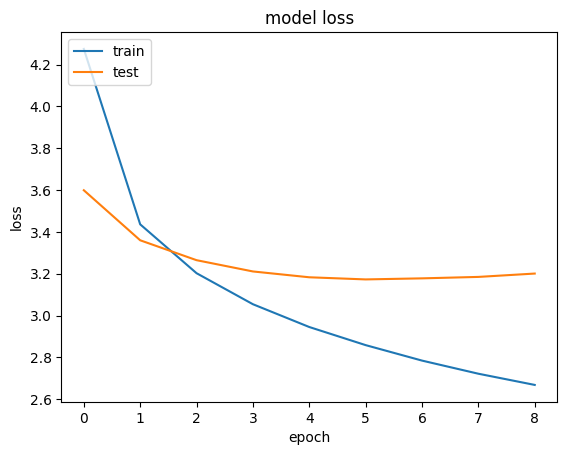

In [99]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [100]:
model.evaluate(test_generator)

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 310ms/step - loss: 3.1421


3.1334445476531982

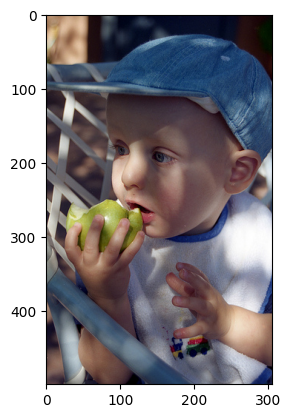

startseq a baby is holding a toy endseq


In [102]:
img_file = test_df["filename"].sample(1).values[0]
img = Image.open(f"flickr30k-images/{img_file}")
plt.imshow(img)
plt.show()

img_tensor = tf.convert_to_tensor(img)
img_tensor = tf.image.resize(img_tensor, [224, 224])
img_tensor = pretrained_cnn_densenet169.preprocess_image(img_tensor)
img_tensor = tf.expand_dims(img_tensor, axis=0)
img_features = pretrained_cnn_densenet169.model(img_tensor)

max_caption_length = 100
length = 0
caption = 'startseq'
while length <= max_caption_length:
  seq = pad_sequences(tokenizer.texts_to_sequences([caption]), maxlen=test_generator.max_seq_len, padding="post")
  predictions = model.predict([img_features, seq], verbose=0)
  predicted_token = np.argmax(predictions[0])
  word = tokenizer.index_word[predicted_token]

  caption += ' '
  caption += word

  if word == 'endseq':
    break

  length += 1

print(caption)

In [164]:
flickr30k_df.head()

captions               sentids  \
0  [startseq two young guys with shaggy hair look...       [0, 1, 2, 3, 4]   
1  [startseq several men in hard hats are operati...       [5, 6, 7, 8, 9]   
2  [startseq a child in a pink dress is climbing ...  [10, 11, 12, 13, 14]   
3  [startseq someone in a blue shirt and hat is s...  [15, 16, 17, 18, 19]   
4  [startseq two men one in a gray shirt one in a...  [20, 21, 22, 23, 24]   

   split        filename  img_id  
0  train  1000092795.jpg       0  
1  train    10002456.jpg       1  
2  train  1000268201.jpg       2  
3  train  1000344755.jpg       3  
4  train  1000366164.jpg       4

In [165]:
# Define a class that builds a data generator object for dynamically loading data
class CustomDataGenerator(DataGenerator):
  def __init__(self, df, vocab_size, im_width, im_height, max_seq_len=113, batch_size=32, shuffle=True):
    super().__init__(df, batch_size, shuffle)
    self.data = df
    self.vocab_size = vocab_size
    self.im_width = im_width
    self.im_height = im_height
    self.max_seq_len = max_seq_len

  # Customizes the object accessor [] to retrieve the batch at a particular index
  def __getitem__(self, idx):

    # Get the range of indices for this batch
    low = idx * self.batch_size
    high = min(low + self.batch_size, len(self.data))

    # Retrieve the batch
    batch = self.data[low:high]

    batch_images = batch["filename"]
    batch_captions = batch["captions"]

    image_tensors = []
    caption_sequences = []
    y = []

    for img, captions in zip(batch_images, batch_captions):
      # Load and preprocess image
      img_tensor = self.load_image_from_file(img)

      # Pick random caption
      caption_idx = random.randint(0, 4)
      caption = captions[caption_idx]
      for caption in captions:
        encoding = tokenizer.texts_to_sequences([caption])[0]

        for i in range(1, len(encoding)):
            # Create input and output sequences from the captions, e.g.
            # <START> -> a
            # <START> a -> sample
            # <START> a sample -> caption

          caption_input, output = encoding[:i], encoding[i]
          caption_input = pad_sequences(
              [caption_input],
              maxlen=self.max_seq_len,
              padding="post",
              truncating="post"
          )[0]
          output = to_categorical([output], num_classes=self.vocab_size)[0]

          image_tensors.append(img_tensor)
          caption_sequences.append(caption_input)
          y.append(output)

    # Return a batch of images and captions
    return (np.array(image_tensors), np.array(caption_sequences)), np.array(y)

  # Customize built in len() method to return the number of batches per epoch
  def __len__(self):
    return int(np.ceil(len(self.data) / float(self.batch_size)))

  # If shuffle is enabled, shuffle the data at the end of each epoch
  def on_epoch_end(self):
    if self.shuffle:
      self.data = self.data.sample(frac=1).reset_index(drop=True)

  # Helper function to load and preprocess an image from disk
  def load_image_from_file(self, filename):
    img = Image.open(f"flickr30k-images/{filename}")
    img_tensor = tf.convert_to_tensor(img)
    img_tensor = tf.image.resize(img_tensor, [self.im_width, self.im_height])
    img_tensor = img_tensor/255.0
    return img_tensor


In [175]:
generator = CustomDataGenerator(train_df, (len(tokenizer.word_index) + 1), 128, 128, batch_size=4)
print(f"Batches per epoch: {len(generator)}")

# Take the first batch
inputs, output = generator[0]
print(f"Images shape: {inputs[0].shape}")
print(f"Caption input shape: {inputs[1].shape}")
print(f"Ground truth shape: {output.shape}")

Batches per epoch: 7250
Images shape: (229, 128, 128, 3)
Caption input shape: (229, 113)
Ground truth shape: (229, 18712)


In [168]:
mini_train_df = train_df.sample(n=8000)

In [179]:
# Instantiate generators for each data split
batch_size = 4
im_width = 64
im_height = 64
vocab_size = len(tokenizer.word_index) + 1

train_generator = CustomDataGenerator(train_df, vocab_size, im_width, im_height, batch_size=batch_size)
test_generator = CustomDataGenerator(test_df, vocab_size, im_width, im_height, batch_size=batch_size)
val_generator = CustomDataGenerator(val_df, vocab_size, im_width, im_height, batch_size=batch_size)

image_input_shape = train_generator[0][0][0].shape[1:]
caption_input_shape = train_generator[0][0][1].shape[1:]

print(image_input_shape, caption_input_shape)

(64, 64, 3) (113,)


In [186]:
# Image Encoder
image_input = Input(shape=image_input_shape)
c1 = Conv2D(16, 2, activation="relu")(image_input)
c2 = Conv2D(32, 2, activation="relu")(c1)
c3 = Conv2D(64, 2, activation="relu")(c2)
p1 = GlobalAveragePooling2D()(c3)
flatten = Flatten()(p1)
image_encoder = Dense(256, activation="relu")(flatten)

# Language Encoder
caption_input = Input(shape=caption_input_shape)
language_encoder1 = Embedding(vocab_size, 256, mask_zero=True)(caption_input)
language_encoder2 = LSTM(256, return_sequences=True)(language_encoder1)
language_encoder3 = Dropout(0.2)(language_encoder2)
language_encoder4 = LSTM(256)(language_encoder3)

# Decoder
decoder1 = Add()([image_encoder, language_encoder4])
decoder2 = Dense(512, activation="relu")(decoder1)
dropout = Dropout(0.2)(decoder2)
decoder3 = Dense(256, activation="relu")(dropout)
output = Dense(units=vocab_size, activation="softmax")(decoder3)
model = Model([image_input, caption_input], output)

In [187]:
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43            │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_107 (Conv2D)       │ (None, 63, 63, 16)     │            208 │ input_layer_43[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_108 (Conv2D)       │ (None, 62, 62, 32)     │          2,080 │ conv2d_107[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_44            │ (None, 113)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_109 (Conv2D)       │ (None, 61, 61, 64)     │          8,256 │ conv2d_108[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_19 (Embedding)  │ (None, 113, 256)       │      4,790,272 │ input_layer_44[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_19 (NotEqual)   │ (None, 113)            │              0 │ input_layer_44[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ conv2d_109[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_37 (LSTM)            │ (None, 113, 256)       │        525,312 │ embedding_19[0][0],    │
│                           │                        │                │ not_equal_19[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 64)             │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_30 (Dropout)      │ (None, 113, 256)       │              0 │ lstm_37[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_69 (Dense)          │ (None, 256)            │         16,640 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_38 (LSTM)            │ (None, 256)            │        525,312 │ dropout_30[0][0],      │
│                           │                        │                │ not_equal_19[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_19 (Add)              │ (None, 256)            │              0 │ dense_69[0][0],        │
│                           │                        │                │ lstm_38[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_70 (Dense)          │ (None, 512)            │        131,584 │ add_19[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_31 (Dropout)      │ (None, 512)            │              0 │ dense_70[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_71 (Dense)     

 Total params: 10,939,976 (41.73 MB)

 Trainable params: 10,939,976 (41.73 MB)

 Non-trainable params: 0 (0.00 B)

In [188]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=3,
    verbose=1,
    restore_best_weights=True
)
model.compile(loss='categorical_crossentropy', optimizer='adam')
history = model.fit(train_generator, validation_data=val_generator, epochs=15, callbacks=[es_callback])

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7250/7250 ━━━━━━━━━━━━━━━━━━━━ 682s 93ms/step - loss: 4.5907 - val_loss: 3.7299
Epoch 2/15
7250/7250 ━━━━━━━━━━━━━━━━━━━━ 604s 83ms/step - loss: 3.6268 - val_loss: 3.5553
Epoch 3/15
7250/7250 ━━━━━━━━━━━━━━━━━━━━ 591s 81ms/step - loss: 3.4202 - val_loss: 3.4836
Epoch 4/15
7250/7250 ━━━━━━━━━━━━━━━━━━━━ 584s 81ms/step - loss: 3.2974 - val_loss: 3.4407
Epoch 5/15
7250/7250 ━━━━━━━━━━━━━━━━━━━━ 628s 87ms/step - loss: 3.2165 - val_loss: 3.4175
Epoch 6/15
7250/7250 ━━━━━━━━━━━━━━━━━━━━ 588s 81ms/step - loss: 3.1617 - val_loss: 3.3977
Epoch 7/15
7250/7250 ━━━━━━━━━━━━━━━━━━━━ 614s 85ms/step - loss: 3.1097 - val_loss: 3.3884
Epoch 8/15
7250/7250 ━━━━━━━━━━━━━━━━━━━━ 582s 80ms/step - loss: 3.0728 - val_loss: 3.3888
Epoch 9/15
7250/7250 ━━━━━━━━━━━━━━━━━━━━ 602s 83ms/step - loss: 3.0420 - val_loss: 3.3857
Epoch 10/15
7250/7250 ━━━━━━━━━━━━━━━━━━━━ 595s 82ms/step - loss: 3.0168 - val_loss: 3.3762
Epoch 11/15
7250/7250 ━━━━━━━━━━━━━━━━━━━━ 588s 81ms/step - loss: 2.9945 - val_loss: 3.3858
Epoch 12

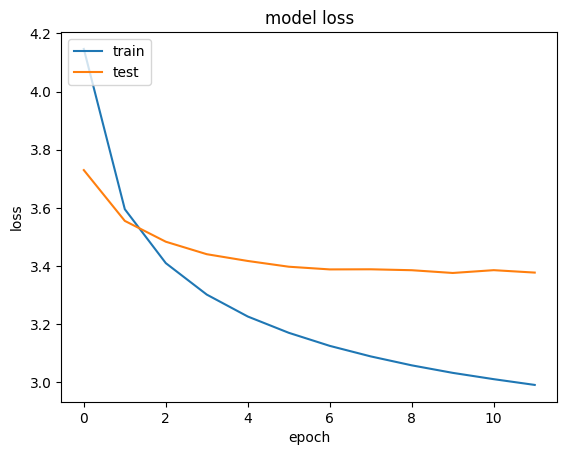

In [189]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

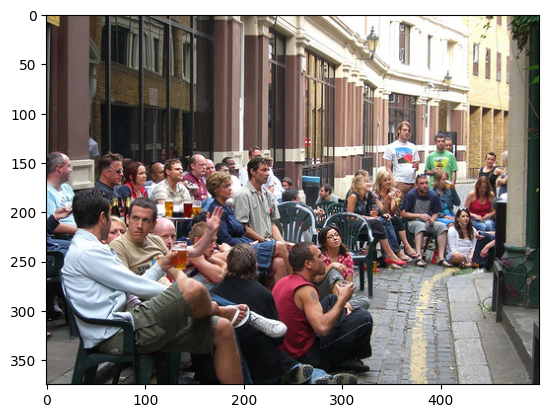

startseq a man in a blue shirt and a woman in a black shirt are standing in front of a crowd endseq


In [199]:
img_file = test_df["filename"].sample(1).values[0]
img = Image.open(f"flickr30k-images/{img_file}")
plt.imshow(img)
plt.show()

img_tensor = tf.convert_to_tensor(img)
img_tensor = tf.image.resize(img_tensor, [64, 64])
img_tensor = img_tensor/255.0
img_tensor = tf.expand_dims(img_tensor, axis=0)

max_caption_length = 100
length = 0
caption = 'startseq'
while length <= max_caption_length:
  seq = pad_sequences(tokenizer.texts_to_sequences([caption]), maxlen=test_generator.max_seq_len, padding="post")
  predictions = model.predict([img_tensor, seq], verbose=0)
  predicted_token = np.argmax(predictions[0])
  word = tokenizer.index_word[predicted_token]

  caption += ' '
  caption += word

  if word == 'endseq':
    break

  length += 1

print(caption)

In [ ]:
from einops import repeat

# Repeat each image in the batch 4 times along a new dimension
repeated = repeat(train_generator[0][0][0], 'b c h w -> (repeat b) c h w', repeat=119)

In [ ]:
repeated.shape

(3808, 128, 128, 3)

In [ ]:
!pip install --upgrade einops

In [ ]:
image_input = Input(shape=image_input_shape)

c1 = Conv2D(32, 3, activation="relu")(image_input)
c2 = Conv2D(32, 3, activation="relu")(c1)
p1 = GlobalAveragePooling2D()(c2)
d1 = Dense(units=12)(p1)
print(d1.shape)
expand = Reshape((1, 12))(d1)
print(expand.shape)
repeated = Lambda(lambda x: tf.tile(x, [119, 1, 1]))(expand)
print(repeated.shape)
#repeat = RepeatVector(train_generator.caption_encoder.seq_length-1)(d1)
#im = Reshape((1, 12))(d1)
#repeated = repeat(d1, 'b c h w -> (repeat b) c h w', repeat=119)

caption_input = Input(shape=caption_input_shape)

e = Embedding(vocab_size, 12, mask_zero=True)(caption_input)
#mask = e._keras_mask
#print(mask)
concat = Concatenate(axis=1)([repeated, e])
masked_concat = Masking()(concat)

lstm = LSTM(128)(masked_concat)
d2 = Dense(256, activation="relu")(lstm)
output = Dense(units=vocab_size, activation="softmax")(d2)

model = Model([image_input, caption_input], output)

AttributeError: 'KerasTensor' object has no attribute 'numpy'

In [ ]:
from tensorflow.keras.layers import Layer

In [ ]:
class DuplicateImageFeatures(Layer):
  def __init__(self, seq_length):
    super(DuplicateImageFeatures, self).__init__()
    self.seq_length = seq_length

  def call(self, input):
    expand = tf.expand_dims(input, axis=1)
    tile = tf.tile(expand, [1, self.seq_length, 1])
    return tile

In [ ]:
image_input = Input(shape=image_input_shape)

c1 = Conv2D(32, 3, activation="relu")(image_input)
c2 = Conv2D(16, 3, activation="relu")(c1)
p1 = GlobalAveragePooling2D()(c2)
image_features = Dense(units=128)(p1)

tile = DuplicateImageFeatures(119)(image_features)

#expand = Reshape((1, 128))(image_features)
#tile = Lambda(lambda x: tf.tile(x, [1, 119, 1]))(expand)

#repeat = RepeatVector(train_generator.caption_encoder.seq_length-1)(image_features)

caption_input = Input(shape=caption_input_shape)
e = Embedding(vocab_size, 128, mask_zero=False)(caption_input)
lstm1 = LSTM(128, return_sequences=True)(e)


add = Add()([tile, lstm1])
#concat = Concatenate(axis=-1)([repeat, lstm1])
lstm2 = LSTM(128)(concat)
d2 = Dense(256, activation="relu")(lstm2)


output = Dense(units=vocab_size, activation="softmax")(d2)

model2 = Model([image_input, caption_input], output)

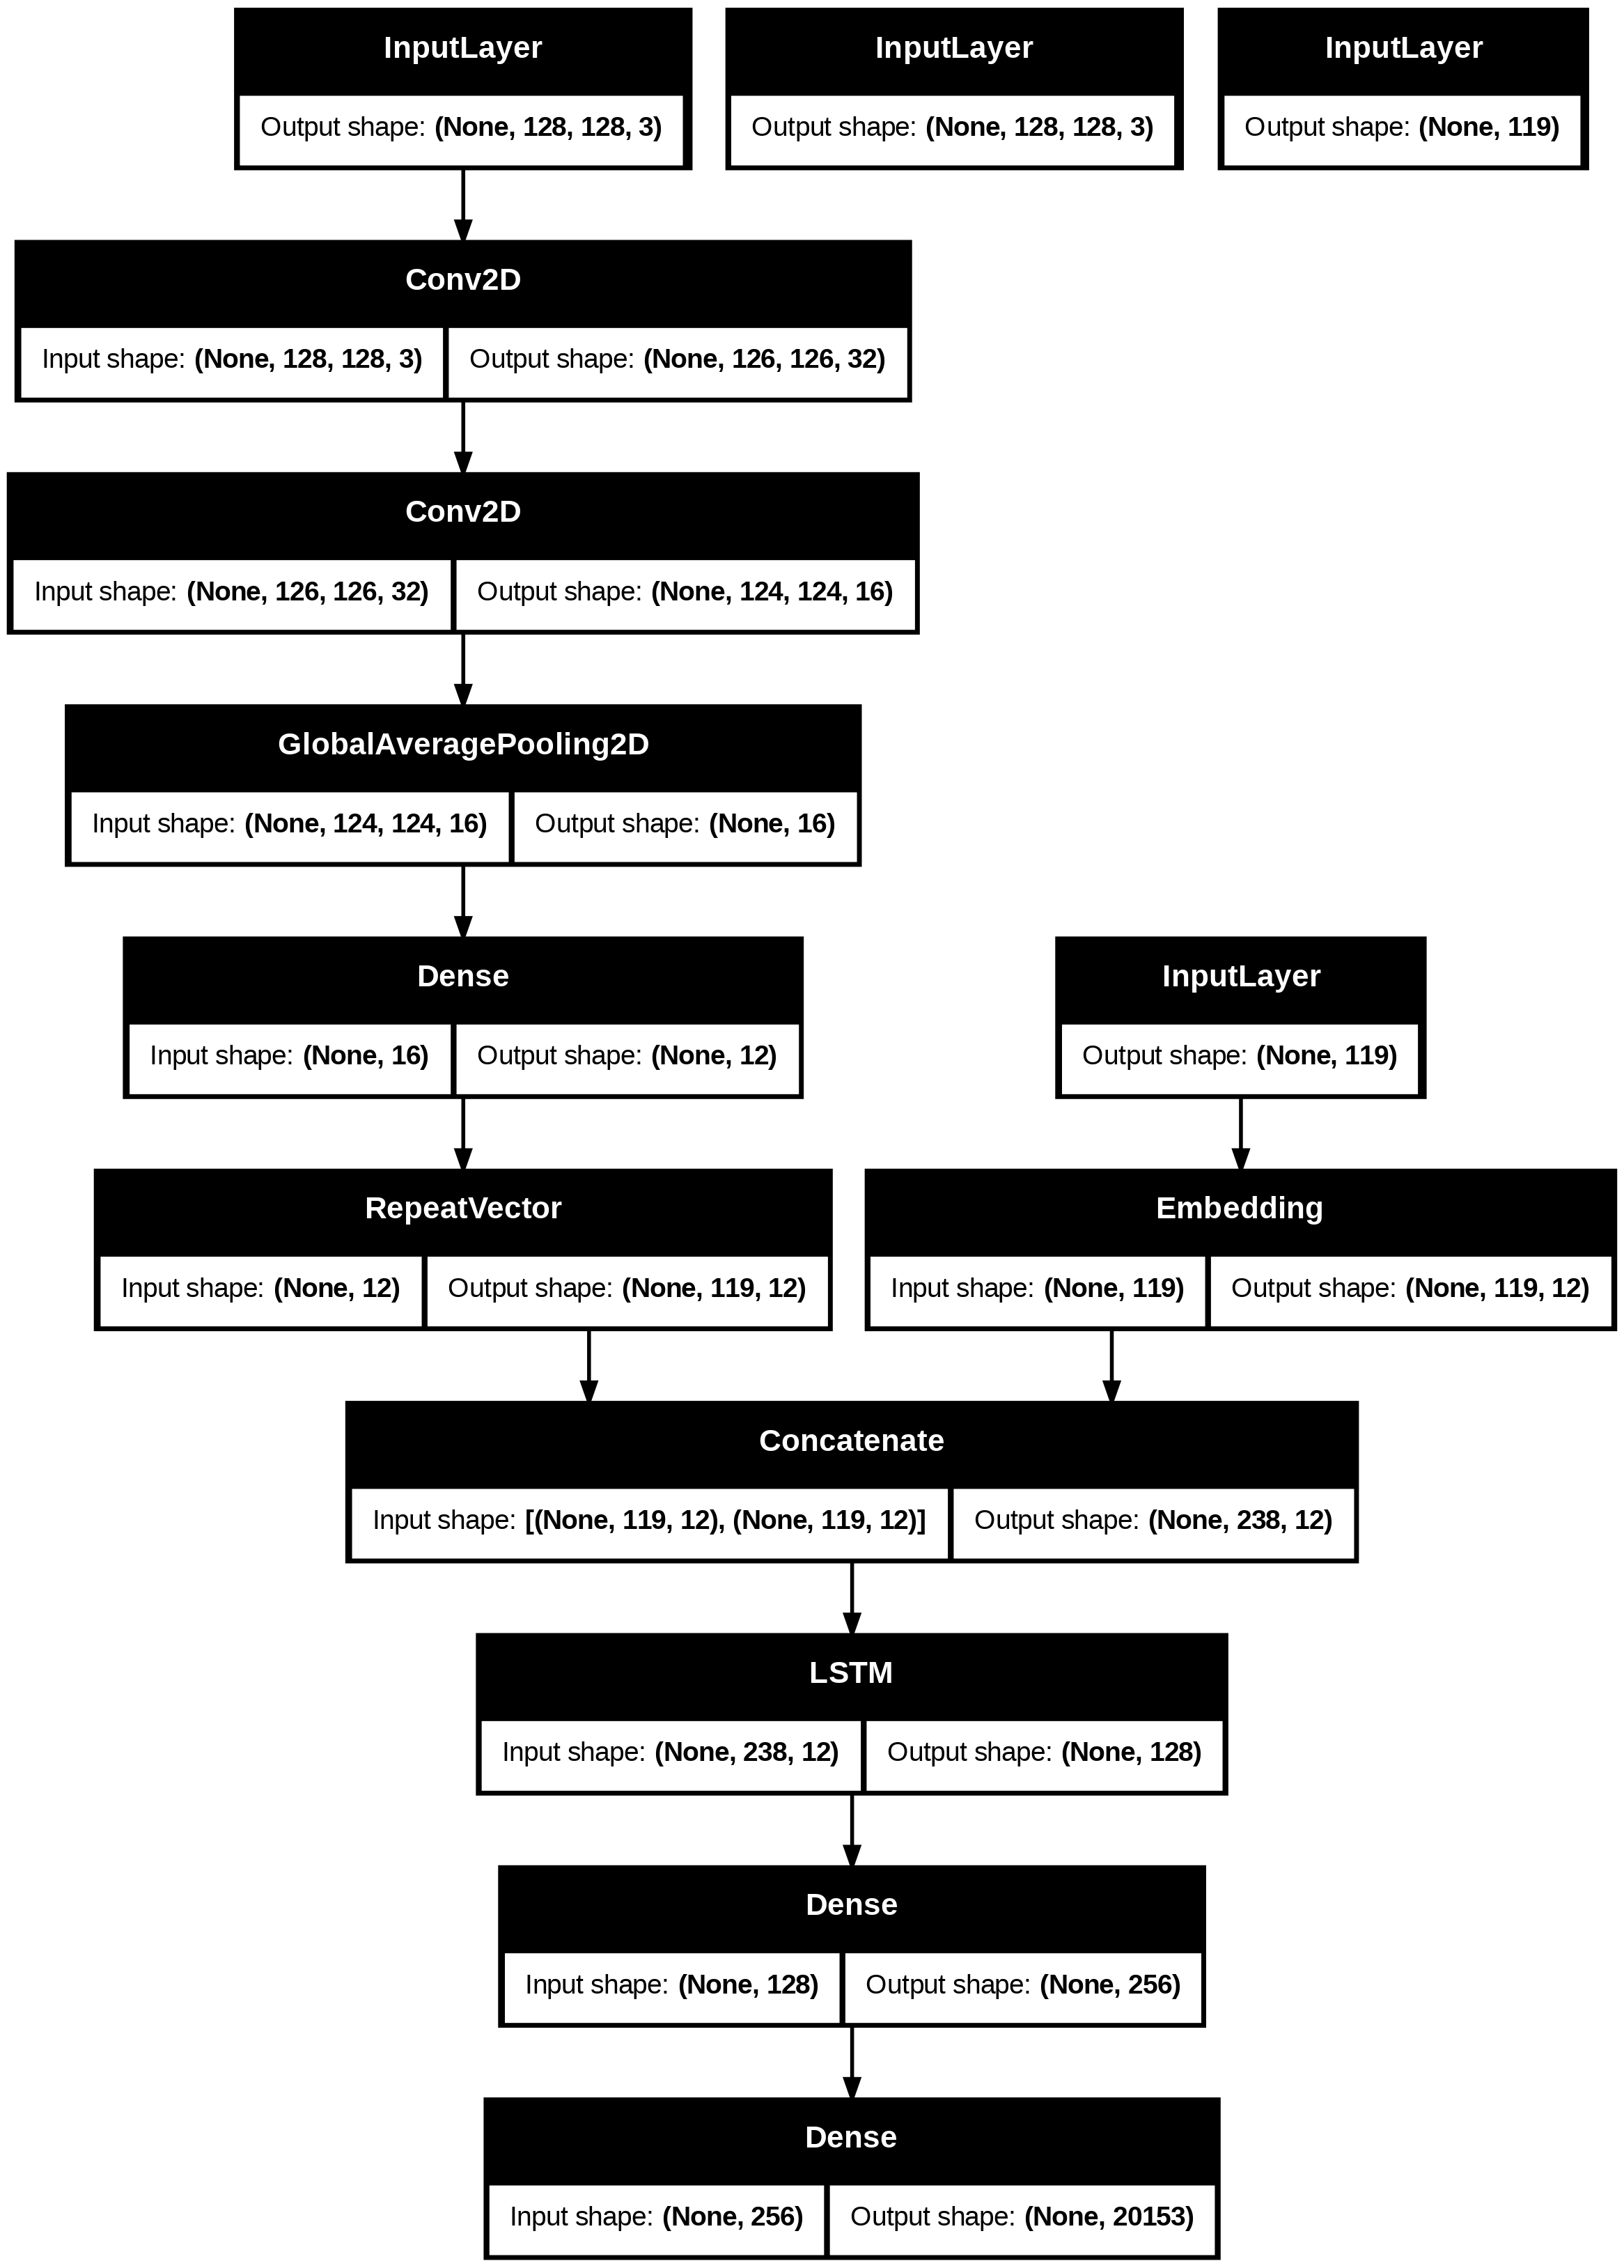

In [ ]:
plot_model(model, show_shapes=True)

#### Caption Tokenization and Encoding

In [ ]:
# Define a method to create a token vocabulary from the caption text corpus
def create_vocabulary(captions):

  # Create a set to store unique tokens
  unique_tokens = set()

  # Add the start and end sequence tokens to the vocabulary
  special_tokens = ["<START>", "<END>"]
  unique_tokens.update(special_tokens)

  # Tokenize each caption and add its tokens to the vocabulary
  for caption in captions:
    caption_tokens = word_tokenize(caption)
    unique_tokens.update(caption_tokens)
  return unique_tokens

# Test on the first caption
single_caption_vocab = create_vocabulary(all_captions_cleaned[:1])
print(all_captions_cleaned[:1])
print(single_caption_vocab)

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq']
{'startseq', 'hands', 'guys', 'at', 'with', 'hair', 'shaggy', 'endseq', 'out', 'the', 'two', '<END>', 'look', '<START>', 'in', 'hanging', 'young', 'while', 'their', 'yard'}


In [ ]:
# Create the full vocabulary (raw captions)
full_vocab = create_vocabulary(all_captions_raw)

# Print vocab size (raw captions size)
print(f"Vocab size (without text cleaning): {len(full_vocab)}")

In [ ]:
# Create the full vocabulary (cleaned captions)
full_vocab = create_vocabulary(all_captions_cleaned)

# Print vocab size (cleaned captions)
print(f"Vocab size (after text cleaning): {len(full_vocab)}")

In [ ]:
# Define a class that creates a custom caption encoder object that handles tokenizing and
# encoding/decoding a set of captions
class CustomCaptionEncoder(CaptionEncoder):
  def __init__(self, vocab, seq_length):
    # Set the vocabulary, vocabulary size, and length of the sequences
    self.vocab = vocab
    self.vocab_size = len(vocab)
    self.seq_length = seq_length

    # Define mappings for token to id and id to token
    # ID 0 is reserved for padding
    self.token_to_id = {token: id+1 for id, token in enumerate(vocab)}
    self.id_to_token = {id: token for token, id in self.token_to_id.items()}

  def encode(self, caption):
    # Add the start sequence token to the beginning on the caption tokens
    caption_tokens = ["<START>"] + word_tokenize(caption)

    # Convert each token to its id
    encoding = [self.token_to_id[token] for token in caption_tokens]

    # If the sequence is too short, pad it to the sequence length
    if len(encoding) < self.seq_length-1:
      padding = [0] * (self.seq_length - 1 - len(encoding))
      encoding.extend(padding)
    # If the sequence is too long, truncate it to the sequence length
    else:
      encoding = encoding[:self.seq_length-1]

    # Add the end sequence token
    end_token = self.token_to_id["<END>"]
    encoding.extend([end_token])

    return encoding

  def decode(self, encoding):
    # Convert the encoding back into tokens
    return [self.id_to_token[id] for id in encoding if id != 0]


In [ ]:
# Test the custom caption encoder on the vocabulary from a single caption
encoder = CustomCaptionEncoder(single_caption_vocab, 25)
print(f"Token to ID mapping: {encoder.token_to_id}")
print(f"ID to Token mapping: {encoder.id_to_token}\n")

# Encode the first caption
encoded_caption = encoder.encode(all_captions_cleaned[0])
print(f"Encoded caption: {encoded_caption}")

# Decode the encoded caption
print(f"Decoded caption: {encoder.decode(encoded_caption)}")

In [ ]:
# Create a custom caption encoder on the full vocabulary to use in the models
custom_caption_encoder = CustomCaptionEncoder(full_vocab, 50)

###  VGG16 + LSTM

In [ ]:
flickr30k_df.head()

captions               sentids  \
0  [Two young guys with shaggy hair look at their...       [0, 1, 2, 3, 4]   
1  [Several men in hard hats are operating a gian...       [5, 6, 7, 8, 9]   
2  [A child in a pink dress is climbing up a set ...  [10, 11, 12, 13, 14]   
3  [Someone in a blue shirt and hat is standing o...  [15, 16, 17, 18, 19]   
4  [Two men, one in a gray shirt, one in a black ...  [20, 21, 22, 23, 24]   

   split        filename  img_id  
0  train  1000092795.jpg       0  
1  train    10002456.jpg       1  
2  train  1000268201.jpg       2  
3  train  1000344755.jpg       3  
4  train  1000366164.jpg       4

In [ ]:
len(flickr30k_df)

31014

In [ ]:
def process_captions(captions):
  return str(captions[0][0])

In [ ]:

flickr30k_df['caption'] = flickr30k_df[['captions']].apply(process_captions, axis=1)
flickr30k_df.head()


<ipython-input-10-006753dda8c5>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return str(captions[0][0])


captions               sentids  \
0  [Two young guys with shaggy hair look at their...       [0, 1, 2, 3, 4]   
1  [Several men in hard hats are operating a gian...       [5, 6, 7, 8, 9]   
2  [A child in a pink dress is climbing up a set ...  [10, 11, 12, 13, 14]   
3  [Someone in a blue shirt and hat is standing o...  [15, 16, 17, 18, 19]   
4  [Two men, one in a gray shirt, one in a black ...  [20, 21, 22, 23, 24]   

   split        filename  img_id  \
0  train  1000092795.jpg       0   
1  train    10002456.jpg       1   
2  train  1000268201.jpg       2   
3  train  1000344755.jpg       3   
4  train  1000366164.jpg       4   

                                             caption  
0  Two young guys with shaggy hair look at their ...  
1  Several men in hard hats are operating a giant...  
2  A child in a pink dress is climbing up a set o...  
3  Someone in a blue shirt and hat is standing on...  
4  Two men, one in a gray shirt, one in a black s...

In [ ]:
print(flickr30k_df.dtypes)

captions    object
sentids     object
split       object
filename    object
img_id       int64
caption     object
dtype: object


In [ ]:
!pip install visualkeras


In [ ]:
#necessary preprocessing libraries:
from tqdm.notebook import tqdm
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import load_img, img_to_array
# The Tokenizer class has moved to tensorflow.keras.preprocessing.text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences # Moved to tensorflow.keras.utils
from tensorflow.keras.utils import to_categorical # Moved to tensorflow.keras.utils
from tensorflow.keras.models import Model # Moved to tensorflow.keras.models
from tensorflow.keras.utils import plot_model
import pickle
# layers:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Flatten, add # Moved to tensorflow.keras.layers

In [ ]:
# function for image and label visualization

def display_images(temp_df):
    def readImage(path,img_size=224):
        img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
        img = img_to_array(img)
        img = img/255.
        return img
    from textwrap import wrap
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(5):
        n+=1
        plt.subplot(5,5,n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(os.path.join('/content/flickr30k-images',temp_df['filename'].iloc[i]))
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df['caption'].iloc[i], 20)))
        plt.axis("off")

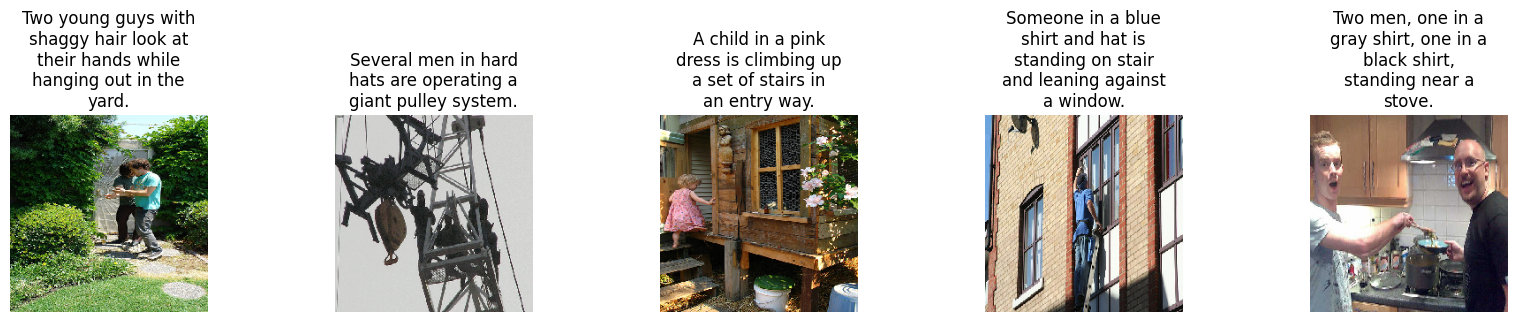

In [ ]:
display_images(flickr30k_df[['filename','caption']])

In [ ]:
img_model = VGG16()
# restructure the model (exclude the last dense layer):
img_model = Model(inputs = img_model.inputs, outputs = img_model.layers[-2].output)

display(img_model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


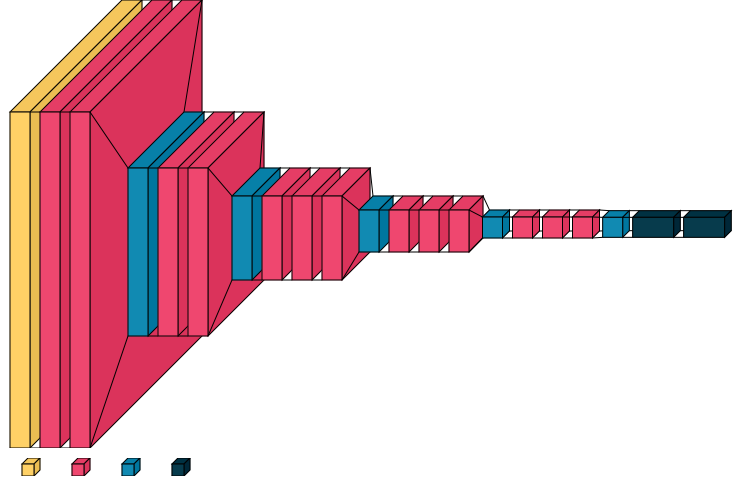

In [ ]:
import visualkeras
visualkeras.layered_view(img_model, draw_volume=True, scale_xy=1.5,scale_z=0.01, legend=True, type_ignore=[Flatten,Dropout])

In [ ]:
# function for feature extraction from images:
def feature_extraction(model,path,count=500):
    features = {}
    img_size = 224
    total = 0

    for img_name in tqdm(os.listdir(path)):
        img_path = os.path.join(path,img_name)
        # load image from file
        try:
          img = load_img(img_path, target_size=(img_size,img_size))
        except:
          print('ERROR ' + img_path)
          continue
        # convert image to numpy array
        img = img_to_array(img)
        # reshape and preprocess image data for model
        img = np.expand_dims(img,axis=0)
        img = preprocess_input(img)
        # extract features
        feature = model.predict(img, verbose=0)
        # get image ID:
        img_id = img_name.split('.')[0]
        # store feature
        features[img_id]=feature
        total += 1
        if total == count:
          break
    return features

In [ ]:
%%time
BASE_DIR = '/content/'
path = os.path.join(BASE_DIR,'flickr30k-images')
features = feature_extraction(img_model,path)

  0%|          | 0/31784 [00:00<?, ?it/s]

CPU times: user 45.5 s, sys: 1.56 s, total: 47 s
Wall time: 58.9 s


In [ ]:
with open (os.path.join(BASE_DIR,'features_dict.pkl'),'wb') as f:
    pickle.dump(features,f)

In [ ]:
#features
print((features['2934359101']))

[[0.         0.25650245 1.5987698  ... 0.         0.         0.        ]]


In [ ]:
print(len(features))

500


In [ ]:
def clean_txt(text):
    import re
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub('#\S+','',text)
    text = re.sub(r'@\S+','', text)
    text = re.sub(r'[^A-Za-z]+',' ',text)
    text = re.sub(r'\s+',' ',text)
    text = 'stseq '+' '.join([word for word in text.split() if len(word)>1])+' enseq'
    return text

In [ ]:
def store_captions(data):
    captions={}
    for img_name,caption in tqdm(data.values):
        name = img_name.split('.')[0]
        if name not in captions:
          captions[name]=[] # as one image can have multiple captions
        for cap in caption:
          captions[name].append(clean_txt(cap))
    return captions


In [ ]:
captions = store_captions(flickr30k_df[['filename', 'captions']])

  0%|          | 0/31014 [00:00<?, ?it/s]

In [ ]:
first_5_values = list(captions.values())[:5]
print(first_5_values)

[['stseq two young guys with shaggy hair look at their hands while hanging out in the yard enseq', 'stseq two young white males are outside near many bushes enseq', 'stseq two men in green shirts are standing in yard enseq', 'stseq man in blue shirt standing in garden enseq', 'stseq two friends enjoy time spent together enseq'], ['stseq several men in hard hats are operating giant pulley system enseq', 'stseq workers look down from up above on piece of equipment enseq', 'stseq two men working on machine wearing hard hats enseq', 'stseq four men on top of tall structure enseq', 'stseq three men on large rig enseq'], ['stseq child in pink dress is climbing up set of stairs in an entry way enseq', 'stseq little girl in pink dress going into wooden cabin enseq', 'stseq little girl climbing the stairs to her playhouse enseq', 'stseq little girl climbing into wooden playhouse enseq', 'stseq girl going into wooden building enseq'], ['stseq someone in blue shirt and hat is standing on stair an

In [ ]:
print(captions['2934359101'])

['stseq boxer with red helmet has water sprayed into his mouth by his coach in the boxing ring enseq', 'stseq man in red helmet has water squirted in his mouth by another man in boxing ring enseq', 'stseq boxer is being examined in his corner by member of his support team enseq', 'stseq trainer giving water to boxer in the corner enseq', 'stseq man spraying water into boxer mouth enseq']


In [ ]:
# saveing our captions dict
with open (os.path.join(BASE_DIR,'captions.pkl'),'wb') as f:
    pickle.dump(captions,f)

In [ ]:
corpus=[]
for img,data in captions.items():
    for line in data:
        corpus.append(line)

len(corpus)


155070

In [ ]:
corpus[:10]


['stseq two young guys with shaggy hair look at their hands while hanging out in the yard enseq',
 'stseq two young white males are outside near many bushes enseq',
 'stseq two men in green shirts are standing in yard enseq',
 'stseq man in blue shirt standing in garden enseq',
 'stseq two friends enjoy time spent together enseq',
 'stseq several men in hard hats are operating giant pulley system enseq',
 'stseq workers look down from up above on piece of equipment enseq',
 'stseq two men working on machine wearing hard hats enseq',
 'stseq four men on top of tall structure enseq',
 'stseq three men on large rig enseq']

In [ ]:
tok = Tokenizer()
tok.fit_on_texts(corpus)

vocab_size = len(tok.word_index)+1
print(f"Vocab size: {vocab_size}")


Vocab size: 17923


In [ ]:
# get max length of the captions:
max_len = max(len(cap.split()) for cap in corpus)
print(max_len)


74


In [ ]:
img_id = list(captions.keys())
split = int(len(img_id)*0.9)

train = img_id[:split]
test = img_id[split:]

print(len(train))
print(len(test))

27912
3102


In [ ]:
# create a data generator function to get data in batch (avoids session crash)
# this data generator will tokenize and pad the captions in itself and will yield the
def dataGenerator(data_keys,captions,features,tokenizer,max_len,vocab_size,batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key in data_keys:
            if key not in features:
              continue
            n+=1
            data = captions[key]
            for caption in data:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split seq into X,y pairs
                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input seq:
                    in_seq = pad_sequences([in_seq], maxlen=max_len, padding='post')[0]
                    # encode output seq:
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==batch_size:
                X1, X2, y = np.array(X1),np.array(X2),np.array(y)
                yield (X1,X2),y
                X1,X2,y = list(),list(),list()
                n=0

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 74)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 4096)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 74, 256)        │      4,588,288 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 4096)           │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 74, 256)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 74)             │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      1,048,832 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ dropout_1[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense[0][0],           │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 17923)          │      4,606,211 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,834,435 (41.33 MB)

 Trainable params: 10,834,435 (41.33 MB)

 Non-trainable params: 0 (0.00 B)

None
CPU times: user 194 ms, sys: 11 ms, total: 205 ms
Wall time: 777 ms


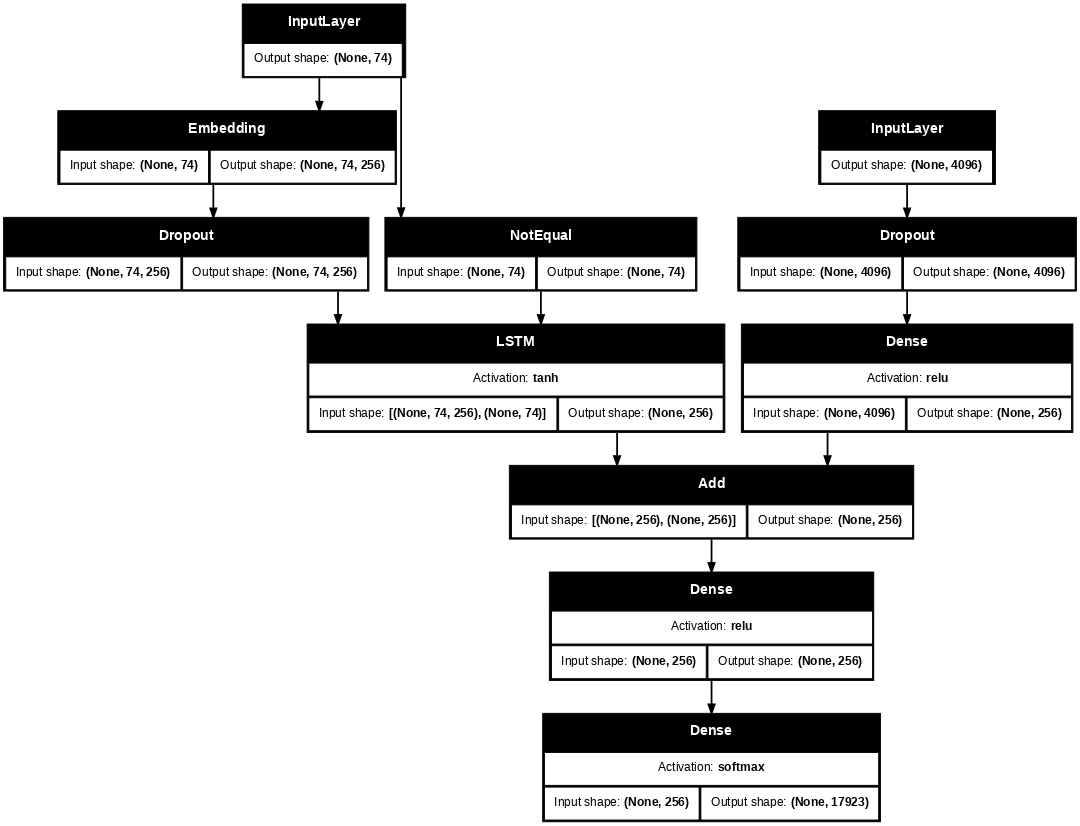

In [ ]:

%%time
# encoder model:

# image feature layers
input1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(input1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
input2 =Input(shape=(max_len,))
se1 = Embedding(vocab_size,256,mask_zero=True)(input2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)


# decoder model
decoder1 = add([fe2,se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input1,input2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# show summary
print(model.summary())

# plot the model
os.chdir(BASE_DIR)
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=False, show_layer_activations=True, dpi=64)

In [ ]:
import tensorflow as tf # make sure tensorflow is installed and imported
import keras #import keras

In [ ]:
%%time
# Training the model:
epochs = 1
batch_size = 64
steps = len(train)//batch_size

es = keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=4)
for i in range(epochs):
    data = dataGenerator(train,captions,features,tok,max_len,vocab_size,batch_size)
    model.fit(data, epochs=1, steps_per_epoch=steps,verbose=1,callbacks=[es])

436/436 ━━━━━━━━━━━━━━━━━━━━ 515s 1s/step - loss: 4.2746
CPU times: user 6min 1s, sys: 3min 43s, total: 9min 45s
Wall time: 9min 27s


In [ ]:
def predict_captions(model,image_feature,tokenizer,max_len):
    def int_to_word(integer,tokenizer):
        for word,val in tokenizer.word_index.items():
            if val==integer:
                return word
        return None
    in_text = 'stseq'
    for i in range(max_len):
        seq = tok.texts_to_sequences([in_text])[0]
        # Ensure padding is on the right by explicitly setting padding='post'
        seq = pad_sequences([seq],maxlen=max_len, padding='post')
        yhat = model.predict([image_feature,seq], verbose=0)
        yhat = np.argmax(yhat)
        word = int_to_word(yhat,tokenizer)
        if word is None:
            break;
        in_text+=" "+word;
        if word=='enseq':
            break;
    return in_text


In [ ]:
%%time
# validate with test data:
actual, predicted = list(), list()

for key in tqdm(test[:20]):
    if key not in features:
        continue
    text = captions[key]
    actual_captions = [caption.split() for caption in text]
    y_pred = predict_captions(model,features[key],tok,max_len)
    predicted_captions = y_pred.split()

    actual.append(actual_captions)
    predicted.append(predicted_captions)

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 18.4 ms, sys: 3.17 ms, total: 21.6 ms
Wall time: 36.5 ms


In [ ]:

# calculate BLEU score:
from nltk.translate.bleu_score import corpus_bleu
print(f"BLEU-1: {corpus_bleu(actual,predicted,weights=(1.0,0,0,0))}")
print(f"BLEU-2: {corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0))}")

ZeroDivisionError: Fraction(0, 0)

In [ ]:
def get_captions(path):
    from PIL import Image
    img_id = path.split('/')[-1]
    img_id = img_id.split('.')[0]
    print(img_id)
    image = Image.open(path)
    data = captions[img_id]
    print('------------------Actual------------------')
    for caption in data:
        print(caption)
    y_pred = predict_captions(model,features[img_id],tok,max_len)
    print('------------------Predicted------------------')
    print(y_pred)
    plt.imshow(image)
    plt.axis('off')

2934359101
------------------Actual------------------
stseq boxer with red helmet has water sprayed into his mouth by his coach in the boxing ring enseq
stseq man in red helmet has water squirted in his mouth by another man in boxing ring enseq
stseq boxer is being examined in his corner by member of his support team enseq
stseq trainer giving water to boxer in the corner enseq
stseq man spraying water into boxer mouth enseq
------------------Predicted------------------
stseq trainer giving water into boxer mouth enseq


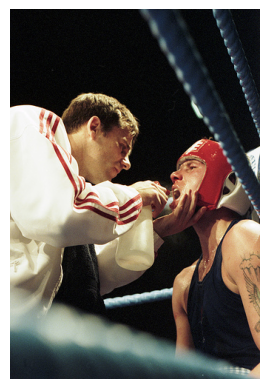

In [ ]:
get_captions('/content/flickr30k-images/2934359101.jpg')

In [ ]:
def generate_captions_from_URL(path,CNN,main_model,tokenizer,max_len):
    img_path = path
    image_url = tf.keras.utils.get_file(origin=path )
    img = load_img(image_url, target_size=(224,224))
    img = img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    feature = CNN.predict(img, verbose=0)

    def int_to_word(integer,tokenizer):
        for word,val in tokenizer.word_index.items():
            if val==integer:
                return word
        return None
    in_text = 'stseq'
    for i in range(max_len):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_len, padding='post')
        yhat = model.predict([feature,seq], verbose=0)
        yhat = np.argmax(yhat)
        word = int_to_word(yhat,tokenizer)
        if word is None:
            break;
        in_text+=" "+word;
        if word=='enseq':
            break;
    from urllib.request import urlopen
    from PIL import Image
    plt.imshow(Image.open(urlopen(path)))
    plt.title(in_text)
    plt.axis('off')
    plt.show()

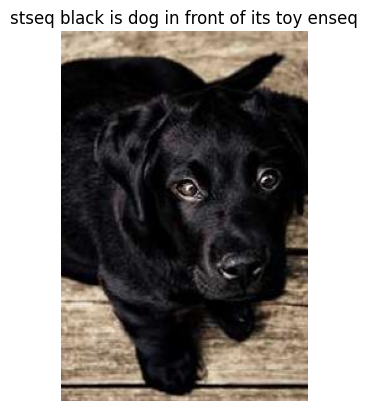

In [ ]:

generate_captions_from_URL(path='https://picsum.photos/id/237/200/300',
                  CNN=img_model,main_model=model,tokenizer=tok,max_len=40)

In [ ]:
encoded_captions['1000092795']

[[2, 19, 27, 500, 7, 1967, 70, 162, 23, 60, 130, 20, 318, 86, 4, 5, 545, 3]]

#### Caption Tokenization and Encoding

### ResNet v2 + GPT2

In [ ]:
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, GlobalAveragePooling2D, Attention, Flatten
from tensorflow.keras.models import Model

from transformers import TFGPT2LMHeadModel, AutoTokenizer
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Sequential

In [ ]:
train_df.head()

captions               sentids  \
0  [Two young guys with shaggy hair look at their...       [0, 1, 2, 3, 4]   
1  [Several men in hard hats are operating a gian...       [5, 6, 7, 8, 9]   
2  [A child in a pink dress is climbing up a set ...  [10, 11, 12, 13, 14]   
3  [Someone in a blue shirt and hat is standing o...  [15, 16, 17, 18, 19]   
4  [Two men, one in a gray shirt, one in a black ...  [20, 21, 22, 23, 24]   

   split        filename  img_id  \
0  train  1000092795.jpg       0   
1  train    10002456.jpg       1   
2  train  1000268201.jpg       2   
3  train  1000344755.jpg       3   
4  train  1000366164.jpg       4   

                                      image_features  
0  (tf.Tensor(0.09507516, shape=(), dtype=float32...  
1  (tf.Tensor(0.63499624, shape=(), dtype=float32...  
2  (tf.Tensor(0.2774256, shape=(), dtype=float32)...  
3  (tf.Tensor(0.650483, shape=(), dtype=float32),...  
4  (tf.Tensor(0.25984168, shape=(), dtype=float32...

In [ ]:
# Load the ResNet50 model
res_model = ResNet50(weights='imagenet')

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Use the model to classify the image
preds = res_model.predict(x)
decoded_predictions = decode_predictions(preds, top=3)[0]
print('Predictions decoded:', decoded_predictions)
print("length of predictions:", len(decoded_predictions))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Predictions decoded: [('n02727426', 'apiary', 0.28241983), ('n03899768', 'patio', 0.16586067), ('n03991062', 'pot', 0.075091034)]
length of predictions: 3


In [ ]:
def get_image_features(decode_predictions):
  feature_names = []
  for i in range(len(decoded_predictions)):
    feature_names.append(decoded_predictions[i][1])

  return feature_names

features:  ['apiary', 'patio', 'pot']


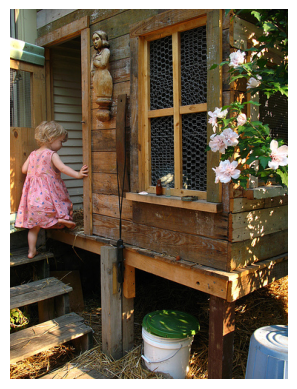

In [ ]:
features = get_image_features(decoded_predictions)
print("features: ", features)
img = Image.open(f"flickr30k-images/{filename}")
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
model_type = "distilgpt2"
# Load GPT-2 model and tokenizer
gpt2_model = TFGPT2LMHeadModel.from_pretrained(model_type)
print(gpt2_model)
tokenizer = AutoTokenizer.from_pretrained(model_type)
print(tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

GPT2TokenizerFast(name_or_path='distilgpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}


In [ ]:
print("caption ex:", train_df['captions'][0][0])
def tokenize_function(train_df):
    return tokenizer(train_df['captions'][0][0])

print(tokenize_function(train_df))

caption ex: Two young guys with shaggy hair look at their hands while hanging out in the yard.
{'input_ids': [7571, 1862, 3730, 351, 427, 363, 1360, 4190, 804, 379, 511, 2832, 981, 10938, 503, 287, 262, 12699, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
tokenizer.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>'}

#### Caption Encoder

In [ ]:
class GPT2CaptionEncoder:
    def __init__(self, tokenizer, seq_length):
        # Initialize tokenizer and sequence length
        self.tokenizer = tokenizer
        self.seq_length = seq_length

        # Add special tokens for padding, start, and end if not present
        special_tokens = {"pad_token": "<PAD>"}
        self.tokenizer.add_special_tokens(special_tokens)

        # Update model embedding size for the new tokens
        gpt2_model.resize_token_embeddings(len(self.tokenizer))

    @property
    def vocab_size(self):
        return self.tokenizer.vocab_size + 1

    def encode(self, caption):
        # Tokenize and add start/end tokens
        encoding = self.tokenizer(
            caption,
            max_length=self.seq_length,
            padding="max_length",
            truncation=True,
            return_tensors="np"
        )
        return encoding["input_ids"].squeeze()  # Return token IDs

    def decode(self, encoding):
        # Decode token IDs back to text
        return self.tokenizer.decode(encoding, skip_special_tokens=True)

    def embed(self, captions):
        # Convert captions to sequences, then use the model's embedding layer
        sequences = [self.encode(caption) for caption in captions]
        sequences = np.array(sequences)
        embedded_captions = gpt2_model.transformer.wte(tf.convert_to_tensor(sequences))
        return embedded_captions

In [ ]:
# Initialize encoder
seq_length = 10  # Adjust based on dataset requirements
gpt2_encoder = GPT2CaptionEncoder(tokenizer, seq_length)

# Example captions
captions = ["A dog running in a park.", "A cat sitting on a couch."]

# Encode captions
encoded = [gpt2_encoder.encode(caption) for caption in captions]
print("Encoded:", encoded)

# Decode back to text
decoded = [gpt2_encoder.decode(enc) for enc in encoded]
print("Decoded:", decoded)

# Get embeddings
embeddings = gpt2_encoder.embed(captions)
print("Embeddings Shape:", embeddings.shape)

Encoded: [array([   32,  3290,  2491,   287,   257,  3952,    13, 50257, 50257,
       50257]), array([   32,  3797,  5586,   319,   257, 18507,    13, 50257, 50257,
       50257])]
Decoded: ['A dog running in a park.', 'A cat sitting on a couch.']
Embeddings Shape: (2, 10, 768)


In [ ]:
print("Special tokens:", tokenizer.all_special_tokens)
print("Tokenizer vocab size:", tokenizer.vocab_size)
print("Caption encoder vocab size:", gpt2_encoder.vocab_size)

Special tokens: ['<|endoftext|>', '<PAD>']
Tokenizer vocab size: 50257
Caption encoder vocab size: 50258


#### Data Generator

In [ ]:
class DataGeneratorGPT2wResNet50(DataGenerator):
  def __init__(self, df, caption_encoder, batch_size=32, shuffle=True):
      """
      Initialize the data generator.
      Args:
          df (pd.DataFrame): DataFrame containing image features and captions.
          caption_encoder (GPT2CaptionEncoder): Encoder for tokenizing captions.
          batch_size (int): Number of samples per batch.
          shuffle (bool): Whether to shuffle the data at the end of each epoch.
      """
      self.data = df
      self.caption_encoder = caption_encoder
      self.batch_size = batch_size
      self.shuffle = shuffle

  def __getitem__(self, idx):
    # Adjust sampling to consider both image features and caption samples
    batch_data = self.data.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]

    # Assuming each data entry has a single image and multiple captions
    batch_size_images = len(batch_data)  # samples aligned with image features
    num_sequences_per_image = len(batch_data['captions'].iloc[0])  # Assumes constant number of captions per image

    # Flatten or adjust such that images and their captions form a uniform batch size
    image_features = np.repeat(np.stack(batch_data["image_features"].values), num_sequences_per_image, axis=0)

    caption_sequences = []
    y = []

    for i in range(batch_size_images):
      for j in range(num_sequences_per_image):
        caption = batch_data['captions'].iloc[i][j]  # Access specific caption
        encoding = self.caption_encoder.encode(caption)

        for k in range(1, len(encoding)):
            caption_input = encoding[:k]
            output = encoding[k]
            caption_input = np.pad(
                caption_input,
                (0, self.caption_encoder.seq_length - len(caption_input)),
                mode="constant",
                constant_values=self.caption_encoder.tokenizer.pad_token_id
            )

            output = to_categorical(output, num_classes=self.caption_encoder.vocab_size)
            caption_sequences.append(caption_input)
            y.append(output)

      return ([np.array(image_features), np.array(caption_sequences)], np.array(y))
  def __len__(self):
      """
      Return the number of batches per epoch.
      """
      return int(np.ceil(len(self.data) / float(self.batch_size)))

  def on_epoch_end(self):
      """
      Shuffle the data at the end of each epoch, if enabled.
      """
      if self.shuffle:
          self.data = self.data.sample(frac=1).reset_index(drop=True)

In [ ]:
train_generator = DataGeneratorGPT2wResNet50(
    df=train_df,
    caption_encoder=gpt2_encoder,
    batch_size=32,
    shuffle=True
)
test_generator = DataGeneratorGPT2wResNet50(
    df=test_df,
    caption_encoder=gpt2_encoder,
    batch_size=32,
    shuffle=True
)

val_generator = DataGeneratorGPT2wResNet50(
    df=val_df,
    caption_encoder=gpt2_encoder,
    batch_size=32,
    shuffle=True
)

In [ ]:
(img_batch, caption_batch), output_sequences_batch = train_generator[0]
# val = train_generator[0]
# print(val)
print(f"Images shape: {img_batch.shape}")
print(f"Caption input shape: {caption_batch.shape}")
print(f"Ground truth shape: {output_sequences_batch.shape}")
print(f"Generator Length: {len(train_generator)}")

Images shape: (160, 2048)
Caption input shape: (45, 10)
Ground truth shape: (45, 50258)
Generator Length: 907


#### Building Model

In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Concatenate, Flatten


In [ ]:
# Constants
vocab_size = gpt2_encoder.vocab_size
embedding_dim = 256
lstm_units = 512
max_caption_length = 10

def create_model():
    # Image input
    image_input = Input(shape=(2048,), name='image_input')  # Image feature shape
    image_features = Dense(512, activation='relu')(image_input)  # Adjust dimensions as needed

    # Caption input
    caption_input = Input(shape=(max_caption_length,), name='caption_input')  # Shape of captions
    caption_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(caption_input)

    # LSTM for the captions
    caption_lstm = LSTM(lstm_units, return_sequences=True)(caption_embedding)

    # Flatten and combine the LSTM output with image features
    caption_lstm_flat = Flatten()(caption_lstm)
    combined = Concatenate()([image_features, caption_lstm_flat])

    # Output layer
    output = Dense(vocab_size, activation='softmax')(combined)

    # Create the model
    model = Model(inputs=[image_input, caption_input], outputs=output)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Create the model
model = create_model()

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'flatten_2' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ caption_input             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 10, 256)        │     12,866,048 │ caption_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, 10)             │              0 │ caption_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_input (InputLayer)  │ (None, 2048)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 10, 512)        │      1,574,912 │ embedding_2[0][0],     │
│                           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 512)            │      1,049,088 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 5120)           │              0 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 5632)           │              0 │ dense_6[0][0],         │
│ (Concatenate)             │                        │                │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 50258)          │    283,103,314 │ concatenate_2[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 298,593,362 (1.11 GB)

 Trainable params: 298,593,362 (1.11 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Assuming you're loading a batch
(img_batch, caption_batch), output_sequences_batch = train_generator[0]

# Find the minimum batch size among images and captions
min_batch_size = min(img_batch.shape[0], caption_batch.shape[0], output_sequences_batch.shape[0])

# Slice to ensure all arrays are of the same size
img_batch = img_batch[:min_batch_size]
caption_batch = caption_batch[:min_batch_size]
output_sequences_batch = output_sequences_batch[:min_batch_size]

# Now all batches have the same size, which is min_batch_size
model.fit([img_batch, caption_batch], output_sequences_batch, epochs=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.2062 - loss: 9.0650


In [ ]:
model.fit(
    train_generator,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=val_generator,  # defined similar to train_generator
    validation_steps=len(val_generator)
)

TypeError: `output_signature` must contain objects that are subclass of `tf.TypeSpec` but found <class 'list'> which is not.

In [ ]:
class ImageCaptioningModel(tf.keras.Model):
    def __init__(self, vocab_size, max_caption_length=120, cnn_input_shape=(224, 224, 3)):
        super(ImageCaptioningModel, self).__init__()

        # Load the pre-trained GPT-2 model
        self.gpt2_model = TFGPT2LMHeadModel.from_pretrained("gpt2")
        for layer in self.gpt2_model.layers:
            layer.trainable = False  # Optionally freeze GPT-2 layers

        # Define the CNN for image feature extraction
        self.image_input = Input(shape=cnn_input_shape, name="image_input")
        self.caption_input = Input(shape=(max_caption_length,), dtype=tf.int32, name="caption_input")

        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation="relu")
        self.pool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu")
        self.pool2 = tf.keras.layers.GlobalAveragePooling2D()
        self.dense_cnn = Dense(256, activation="relu")
        self.dropout_cnn = Dropout(0.5)

        # Projection to GPT-2 embedding space
        self.image_projection = Dense(50257, activation="relu")
        self.caption_projection = Dense(50257, activation="relu")


        # Add a dense layer to project GPT-2 outputs to match the CNN feature dimension
        # self.caption_projection = Dense(256, activation="relu")

        # Define dense layers for combining CNN and GPT-2 features
        self.concat = Concatenate(axis=1)
        self.dense_combined = Dense(256, activation="relu")
        self.dropout_combined = Dropout(0.5)
        self.output_layer = Dense(vocab_size, activation="softmax")

    def call(self, inputs):
        # Split inputs into image and caption parts
        image, caption = inputs

        # CNN forward pass
        x = self.conv1(image)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        image_features = self.dense_cnn(x)
        image_features = self.dropout_cnn(image_features)

        print('image features after cnn', image_features.shape)
        print('caption original shape', caption.shape)
        # Project image features to match GPT-2 embedding size
        image_features = self.image_projection(image_features)

        # Pass caption through GPT-2 model
        gpt2_outputs = self.gpt2_model(caption)
        print(type(gpt2_outputs))
        caption_logits = gpt2_outputs.logits
        print("caption logit shape", caption_logits.shape)

        caption_features = Dense(256, activation="relu")(caption_logits)
        caption_features = tf.reduce_mean(caption_features, axis=1)  # (64, 256)
        print("after caption features Dense 256 and reduce mean - img shape: ", image_features.shape, "caption shape", caption_features.shape)

        combined_features = self.concat([image_features, caption_features])  # (64, 512)
        print("originally combined features", combined_features.shape)
        # Process combined features with a dense layer
        combined_features = self.dense_combined(combined_features)
        combined_features = self.dropout_combined(combined_features)
        print("after dense and dropout combined features", combined_features.shape)
        # Output prediction for each word in the sequence
        output = self.output_layer(combined_features)
        return output

#### Training

In [ ]:
history = image_captioning_model.fit(
    [train_image_features, train_caption_inputs],  # Training Inputs
    train_targets_one_hot,                        # Ground Truth
    batch_size=batch_size,
    epochs=20,
    validation_data=([val_image_features, val_caption_inputs], val_targets_one_hot)
)

In [ ]:
test_loss, test_accuracy = image_captioning_model.evaluate(
    [test_image_features, test_caption_inputs],
    test_targets_one_hot
)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

In [ ]:
# 4. Invoke the model
input_data = (img_batch, caption_batch)
print("img shape:", input_data[0].shape, "caption shape", input_data[1].shape)

predictions = model(input_data)
print(predictions.shape)
print(predictions[0])

# Decode the full sequence of indices to get the generated caption for each image
predicted_captions = []
for sequence in predictions:
    # Decode the full sequence of word indices into a single caption string
    caption = tokenizer.decode(sequence, skip_special_tokens=True)  # Skip special tokens like padding
    predicted_captions.append(caption)

img shape: (64, 224, 224, 3) caption shape (64, 120)
image features after cnn (64, 256)
caption original shape (64, 120)
<class 'transformers.modeling_tf_outputs.TFCausalLMOutputWithCrossAttentions'>
caption logit shape (64, 120, 50257)
after caption features Dense 256 and reduce mean - img shape:  (64, 50257) caption shape (64, 256)
originally combined features (64, 50513)
after dense and dropout combined features (64, 256)
image features after cnn (64, 256)
caption original shape (64, 120)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'image_captioning_model_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


<class 'transformers.modeling_tf_outputs.TFCausalLMOutputWithCrossAttentions'>
caption logit shape (64, 120, 50257)
after caption features Dense 256 and reduce mean - img shape:  (64, 50257) caption shape (64, 256)
originally combined features (64, 50513)
after dense and dropout combined features (64, 256)
(64, 50257)
tf.Tensor(
[1.3851303e-06 4.9406035e-06 1.9392479e-05 ... 3.3863493e-05 1.1885997e-05
 6.5515314e-06], shape=(50257,), dtype=float32)


In [ ]:
# Plot the images with their captions
num_samples = 5
plt.figure(figsize=(15, 6))
for i in range(min(num_samples, len(img_batch))):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img_batch[i])
    plt.axis('off')
    plt.title(predicted_captions[i], wrap=True)

plt.show()

ValueError: Image size of 333934x242 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1500x600 with 5 Axes>

## Appendix

In [ ]:
!pip install -q fiftyone

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.1/943.1 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.1 MB/s eta 0:00:00

In [ ]:
# for coco dataset
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F

In [ ]:
# Using coco dataset with FiftyOne
# https://medium.com/voxel51/the-coco-dataset-best-practices-for-downloading-visualization-and-evaluation-68a3d7e97fb7

feature_classes = ["person", "car", "truck"]
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["detections"],
    classes=feature_classes,
    max_samples=100,
)

session = fo.launch_app(dataset)

In [ ]:
# dataset.get_field_schema()
field_names = list(dataset.get_field_schema().keys())
print(field_names)
display(dataset.first())

In [ ]:
coco_ds = dataset.take(100, seed=222)
print(coco_ds)

In [ ]:
print(coco_ds.first().field_names)

In [ ]:
rand_samples_ds.distinct("ground_truth.detections.label")


In [ ]:
# Load model from zoo and apply it to dataset
model = foz.load_zoo_model("faster-rcnn-resnet50-fpn-coco-torch")
dataset.apply_model(model, label_field="predictions")

# Evaluate `predictions` w.r.t. labels in `ground_truth` field
results = dataset.evaluate_detections(
    "predictions", gt_field="ground_truth", eval_key="eval", compute_mAP=True,
)

# Print the mAP
print("mean Average Precision", results.mAP())
session = fo.launch_app(dataset)

# Convert to evaluation patches
eval_patches = dataset.to_evaluation_patches("eval")
# View patches in the App
session.view = eval_patches

In [ ]:
#Preprocess Captions:
def preprocess_captions(flickr30k_df):
  for index, row in flickr30k_df.iterrows():
    caption = str(row["TEST/caption"][0])
    #remove b' in each caption
    caption = caption[2:]
    #Convert Caption to lowercase
    caption = caption.lower()

    # Delete digits and special chars
    # Replace only works for swapping out one character for another
    caption = caption.replace("[^A-Za-z]", "")

    #Remove extra spaces
    caption = caption.replace("\s+", " ")
    #remove all single letter words in caption
    caption = "<start> " + " ".join([word for word in caption.split() if len(word)>1]) + " <end>"
    flickr30k_df.at[index, "TEST/preprocessed_caption"] = caption

In [ ]:
preprocess_captions(flickr30k_df)

In [ ]:
def load_image_from_file(filename):
  img = Image.open(f"flickr30k-images/{filename}")
  img_tensor = tf.convert_to_tensor(img)
  img_tensor = tf.image.resize(img_tensor, [128, 128])
  img_tensor = img_tensor/255.0
  return img_tensor

# Define a data generator to load and preprocess the images and captions in
# batches to manage memory constraints
def data_generator(df, im_width, im_height, batch_size=32):
  while True:
    data = df.sample(n=batch_size)

    if USE_CROISSANT:
      images = data["image"]
      image_tensors = []
      for img in images:
        img_tensor = tf.convert_to_tensor(img)
        img_tensor = tf.image.resize(img_tensor, [im_width, im_height])
        img_tensor = img_tensor/255.0
        image_tensors.append(img_tensor)
    else:
      image_files = data["filename"]
      with ThreadPoolExecutor() as executor:
        image_tensors = list(executor.map(load_image_from_file, image_files))

    image_captions = []
    batch_captions = data["captions"]
    for captions in batch_captions:
      caption_idx = random.randint(0, 4)
      caption = captions[caption_idx]

      encoding = caption_encoder.encode(caption)
      image_captions.append(caption)

    yield np.array(image_tensors), np.array(image_captions)

images, captions = next(data_generator(train_df, 224, 224, batch_size=16))

In [ ]:
# Simulate a run of 10 epochs to test that the data generator will run through
# all of the images without crashing
batch_size = 128
batches_per_epoch = int(np.ceil(len(train_df)/batch_size))
num_epochs = 1

train_generator = data_generator(train_df, 128, 128, batch_size=batch_size)

test_start_time = time.time()
for epoch in range(num_epochs):
  print(f"Epoch {epoch+1}/{num_epochs}")
  print("Generating batches...")
  epoch_start_time = time.time()

  for batch_idx in range(batches_per_epoch):
    batch = next(train_generator)

  epoch_end_time = time.time()
  print(f"Completed in {np.round((epoch_end_time - epoch_start_time), 3)} s")

test_end_time = time.time()
print(f"Test completed in {np.round((test_end_time - test_start_time), 3)} s.")

Epoch 1/1
Generating batches...
Completed in 63.049 s
Test completed in 63.05 s.
